<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/Revision/fullTrajAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Mon Apr 12 18:25:46 UTC 2021


### **Download Data**

In [1]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [5]:
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')

'D1.1797.gz'

In [6]:
#Previously saved neuron subpopulations
download_file('10.22002/D1.1804','.gz')

#Previously saved neuron pseudotime adata
download_file('10.22002/D1.1806','.gz')

#Previously saved nematocyte pseudotime adata
download_file('10.22002/D1.1805','.gz')

'D1.1805.gz'

In [7]:
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')

#Panther annotations
download_file('10.22002/D1.1820','.gz')

#GO Terms
download_file('10.22002/D1.1822','.gz')

'D1.1822.gz'

In [8]:
#Previously saved ranked pseudotime genes

#Nematocyte trajectory (ranked genes)
#!wget --quiet https://caltech.box.com/shared/static/u19vzppejvt6ky3ysqptt2ia2dqozpkf
download_file('10.22002/D1.1808','.gz')

#Neuron trajectory (ranked genes)
#!wget --quiet https://caltech.box.com/shared/static/ippfug3xt20etmyx08egzpipgmyfc17m
download_file('10.22002/D1.1807','.gz')

'D1.1807.gz'

In [9]:
!gunzip *.gz

In [2]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy==1.6.0

!pip install --quiet louvain

     |████████████████████████████████| 133kB 4.4MB/s 
     |████████████████████████████████| 7.7MB 3.9MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 1.2MB 57.1MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 2.2MB 6.0MB/s 
     |████████████████████████████████| 3.2MB 26.8MB/s 


In [3]:
!pip3 install --quiet rpy2

###**Import Packages** 

In [4]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from scipy import sparse, io
#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

In [10]:
#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('D1.1819'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]


panther_df = pd.read_csv('D1.1820',
            sep="\t",header=None) #skiprows=[0,1,2,3]



goTerm_df = pd.read_csv('D1.1822',
            sep=" ",header=None) #skiprows=[0,1,2,3]

In [11]:
#Read in saved data
bus_fs_combo = anndata.read('D1.1796')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('D1.1797')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
bus_fs_raw.obs['annos'] = pd.Categorical(bus_fs_combo.obs['annos'])
bus_fs_raw.obs['annosSub'] = pd.Categorical(bus_fs_combo.obs['annosSub'])

bus_fs_raw.uns['annos_colors'] = bus_fs_combo.uns['annos_colors']
bus_fs_raw.uns['cellRanger_louvain_colors'] = bus_fs_combo.uns['annosSub_colors']
#bus_fs_raw.uns['annosSub_colors'] = bus_fs_combo.uns['annosSub_colors']
print(bus_fs_raw)

neuron_subpops  = anndata.read('D1.1804') 
print(neuron_subpops)

AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'
AnnData object with n_obs × n_vars = 1387 × 2000
    obs: 'batch',

In [12]:
#Functions used

#Random forest regression to determine best genes to predict pseudotime
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
def runRegr_dptPseudotime(adata,adata_scaled,label='dpt_pseudotime'):
  X = adata.X
  if scipy.sparse.issparse(X):
    X = X.toarray()
  
  #80% training data
  perc = 0.8
  n = np.int(perc*X.shape[0])

  np.random.seed(0)
  indices = np.random.choice(X.shape[0], n, replace=False,)
  X_train = X[indices,:]

  y = adata_scaled.obs[label]
  y_train = y[indices]

  X_test = X[[i for i in range(0,X.shape[0]) if i not in indices],:]
  y_test = y[[i for i in range(0,X.shape[0]) if i not in indices]]

  regr = RandomForestRegressor(random_state=42,max_samples=perc)
  regr.fit(X_train, y_train)
  print(regr.score(X_test, y_test))
  result = permutation_importance(regr, X_test, y_test, n_repeats=5, random_state=42)
  
  return result

#Convert filtered results to dataframe
def resToDF(result,adata):
  neur_gene_res = pd.DataFrame()
  neur_gene_res['Genes'] = adata.var_names
  neur_gene_res['Mean'] = result.importances_mean
  neur_gene_res['Std'] = result.importances_std

  neur_gene_res= neur_gene_res.sort_values('Mean', axis=0, ascending=False)

  neur_gene_res= neur_gene_res[neur_gene_res.Mean > 0]

  print(len(neur_gene_res.Genes))

  return neur_gene_res

#Make dataframe, with 100 marker genes for each cluster + annotations
def annotateResDF(resultDF):
  orthoGene = []
  orthoDescr = []

  pantherNum = []
  pantherDescr = []

  goTerms = []

  genes = resultDF.Genes

  for g in genes:
          
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
  

  resultDF['orthoGene'] = orthoGene
  resultDF['orthoDescr'] = orthoDescr

  resultDF['pantherID'] = pantherNum
  resultDF['pantherDescr'] = pantherDescr

  resultDF['goTerms'] = goTerms
      
  return resultDF
  #list(neurons.uns['rank_genes_groups']['names']['1'])

#Order cells in cell-by-gene matrix by pseudotime
def orderTime(adata):
  sortTime = np.argsort(adata.obs['dpt_pseudotime'])
  newNames = adata.obs_names[list(sortTime)]

  adataRet = adata[newNames,:]
  return adataRet


### **Check gland cell trajectories and/or hair cells**

In [ ]:
#Nematocytes: 11,12,17,23
#Hair cells: 5,10,21
#Gland cells: 27,25,32,34,22
#i-cells:0

full_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([5,10,21,0,11,12,17,23,27,25,32,34,22])]
full_lin


View of AnnData object with n_obs × n_vars = 4728 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [ ]:
io.mmwrite('allLineage.mtx', full_lin.X)

In [ ]:
meta = pd.DataFrame()
meta['cluster'] = full_lin.obs['cellRanger_louvain']
meta['name'] = full_lin.obs['annosSub']
meta['fed'] = full_lin.obs['fed']
meta.head()

cluster                             name    fed
index                                                             
AAACCTGAGAGGGCTT-1      10  Developing Mechanosensory Cells   True
AAACCTGCAAGCTGGA-1       5        Mechanosensory Precursors  False
AAACCTGGTACATGTC-1       5        Mechanosensory Precursors  False
AAACCTGTCATATCGG-1      11                Early Nematocytes   True
AAACCTGTCGGATGGA-1       0                          i-Cells   True

In [ ]:
meta.to_csv('allLinMeta.csv')

In [ ]:
genes = pd.DataFrame()
genes['genes'] = full_lin.var_names

genes.to_csv('genes.csv',index=None)


Lineage with Neurons

In [ ]:
#Check all cells + neurons (31,26,6,9)
neur_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,27,25,32,34,22,5,10,21,11,12,17,23])]
neur_lin

#io.mmwrite('neurLineage.mtx', neur_lin.X)



View of AnnData object with n_obs × n_vars = 6115 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [ ]:
io.mmwrite('neurLineage.mtx', neur_lin.X)

meta = pd.DataFrame()
meta['cluster'] = neur_lin.obs['cellRanger_louvain']
meta['name'] = neur_lin.obs['annosSub']
meta['fed'] = neur_lin.obs['fed']
meta.to_csv('neurLinMeta.csv')

In [ ]:
genes = pd.DataFrame()
genes['genes'] = neur_lin.var_names

genes.to_csv('neurGenes.csv',index=None)

Control test with outgroup i-cell derived cell type (medium oocytes, 2)

In [ ]:
#Check all cells + neurons (31,26,6,9)
control_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,27,25,32,34,22,5,10,21,11,12,17,23,2])]
control_lin

io.mmwrite('controlLineage.mtx', control_lin.X)

meta = pd.DataFrame()
meta['cluster'] = control_lin.obs['cellRanger_louvain']
meta['name'] = control_lin.obs['annosSub']
meta['fed'] = control_lin.obs['fed']
meta.to_csv('controlLinMeta.csv')

In [ ]:
genes = pd.DataFrame()
genes['genes'] = control_lin.var_names

genes.to_csv('controlGenes.csv',index=None)

#### **R URD Analysis**

In [ ]:
# %%R
# #Set up R environment
# install.packages("BiocManager")
# BiocManager::install(version = "3.10")

In [13]:
!sudo apt-get update
!sudo apt-get install libxml2-dev
!sudo apt-get install r-cran-xml
!sudo apt-get install libcurl4-openssl-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [24.7 kB]
Get:12 http://security.ubuntu.

In [14]:
%%R
install.packages("rgl",repos = "http://cran.us.r-project.org")
# Load packages
suppressPackageStartupMessages(library(rgl))

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘sass’, ‘jquerylib’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’, ‘bslib’, ‘lazyeval’, ‘miniUI’, ‘webshot’, ‘htmlwidgets’, ‘shiny’, ‘crosstalk’, ‘manipulateWidget’


R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/sass_0.3.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1837396 bytes (1.8 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [15]:
%%R
if (as.numeric(R.version$major) <= 3 && as.numeric(R.version$minor) < 5) {
  # R < 3.5
  message("Loading Bioconductor (biocLite) to install required packages.")
  source("https://bioconductor.org/biocLite.R")
  message("Installing required packages from Bioconductor.")
  biocLite(c('Biobase', 'S4Vectors', 'AnnotationDbi', 'destiny'), suppressUpdates=T)
} else {
  # R >= 3.5
  if (!requireNamespace("BiocManager", quietly = TRUE)) {
    message("Installing biocManager to install required Bioconductor packages.")
    install.packages("BiocManager")
  }
  message("Installing required packages from Bioconductor (BiocManager).")
  BiocManager::install(c('Biobase', 'S4Vectors', 'AnnotationDbi', 'destiny'), suppressUpdates=T)
}

# Check that Bioconductor installation went smoothly.
if (!requireNamespace("Biobase", quietly = TRUE)) {stop("Failed to install required package 'Biobase' from Bioconductor.")}
if (!requireNamespace("S4Vectors", quietly = TRUE)) {stop("Failed to install required package 'S4Vectors' from Bioconductor.")}
if (!requireNamespace("AnnotationDbi", quietly = TRUE)) {stop("Failed to install required package 'AnnotationDbi' from Bioconductor.")}
if (!requireNamespace("destiny", quietly = TRUE)) {stop("Failed to install required package 'destiny' from Bioconductor.")}

# Install URD (and devtools, if necessary)
if (requireNamespace("devtools", quietly = TRUE)) {
  message("Installing URD")
  devtools::install_github(repo="farrellja/URD")
} else {
  message("Installing devtools")
  install.packages("devtools")
  message("Installing URD")
  devtools::install_github(repo="farrellja/URD")
}

# Check that URD installed.
if (requireNamespace("URD", quietly = TRUE)) {
  message("URD installed successfully!")
  message('You can load it by typing: library("URD")')
  message('Try "?URD" for starting tips.')
} else {
  message("Something went wrong. It doesn't seem that URD installed correctly.")
}

R[write to console]: Installing biocManager to install required Bioconductor packages.

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.12.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 261321 bytes (255 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

Update all/some/none? [a/s/n]: a


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/brio_1.1.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 12069 bytes (11 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


✔  checking for file ‘/tmp/RtmpoVDyu6/remotes3e4a98cf9a/farrellja-URD-0fed8b8/DESCRIPTION’ (341ms)
─  preparing ‘URD’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘URD_1.1.1.tar.gz’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not portable:
     ‘URD/Analyses/QuickStart/URD-QuickStart-AxialMesoderm_files/figure-markdown_github/unnamed-chunk-10-1.png’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not portable:
     ‘URD/Analyses/QuickStart/URD-QuickStart-AxialMesoderm_files/figure-markdown_github/unnamed-chunk-11-1.png’
   Warning in utils::tar(filepath, pkgname, compression = compression, compression_level = 9L,  :
     storing paths of more than 100 bytes is not por

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: Registered S3 method overwritten by 'gplots':
  method         from 
  reorder.factor gdata

R[write to console]: URD installed successfully!

R[write to console]: You can load it by typing: library("URD")

R[write to console]: Try "?URD" for starting tips.



In [16]:
%%R 
suppressPackageStartupMessages(library(URD))
#install.packages("Matrix")
suppressPackageStartupMessages(library(Matrix))

##### **No Neurons**

In [ ]:
%%R 

fullDF <- t(as.matrix(readMM("allLineage.mtx")))

genes <- read.table("genes.csv", header = TRUE, sep = ",")
meta <- read.table("allLinMeta.csv", header = TRUE, sep = ",")

rownames(fullDF) <- genes$genes
colnames(fullDF) <- meta$index

rownames(meta) <- meta$index

head(meta)

                                index cluster                            name
AAACCTGAGAGGGCTT-1 AAACCTGAGAGGGCTT-1      10 Developing Mechanosensory Cells
AAACCTGCAAGCTGGA-1 AAACCTGCAAGCTGGA-1       5       Mechanosensory Precursors
AAACCTGGTACATGTC-1 AAACCTGGTACATGTC-1       5       Mechanosensory Precursors
AAACCTGTCATATCGG-1 AAACCTGTCATATCGG-1      11               Early Nematocytes
AAACCTGTCGGATGGA-1 AAACCTGTCGGATGGA-1       0                         i-Cells
AAACGGGCAAACCCAT-1 AAACGGGCAAACCCAT-1       0                         i-Cells
                     fed
AAACCTGAGAGGGCTT-1  True
AAACCTGCAAGCTGGA-1 False
AAACCTGGTACATGTC-1 False
AAACCTGTCATATCGG-1  True
AAACCTGTCGGATGGA-1  True
AAACGGGCAAACCCAT-1 False


In [ ]:
%%R
#Test removing unknown cluster 17
subMeta <- meta[meta$cluster != 17,]  
subDF <- fullDF[,subMeta$index]

head(subMeta)

                                index cluster                            name
AAACCTGAGAGGGCTT-1 AAACCTGAGAGGGCTT-1      10 Developing Mechanosensory Cells
AAACCTGCAAGCTGGA-1 AAACCTGCAAGCTGGA-1       5       Mechanosensory Precursors
AAACCTGGTACATGTC-1 AAACCTGGTACATGTC-1       5       Mechanosensory Precursors
AAACCTGTCATATCGG-1 AAACCTGTCATATCGG-1      11               Early Nematocytes
AAACCTGTCGGATGGA-1 AAACCTGTCGGATGGA-1       0                         i-Cells
AAACGGGCAAACCCAT-1 AAACGGGCAAACCCAT-1       0                         i-Cells
                     fed
AAACCTGAGAGGGCTT-1  True
AAACCTGCAAGCTGGA-1 False
AAACCTGGTACATGTC-1 False
AAACCTGTCATATCGG-1  True
AAACCTGTCGGATGGA-1  True
AAACGGGCAAACCCAT-1 False


In [ ]:
%%R
knitr::opts_chunk$set(echo = TRUE)
rgl::setupKnitr()

In [ ]:
%%R
# Create an URD object, which will filter the data, then normalize and log-transform it.
lin <- createURD(count.data = fullDF, meta = meta, min.cells=3, min.counts=3)
lin

R[write to console]: 2021-04-14 21:03:05: Filtering cells by number of genes.

R[write to console]: 2021-04-14 21:03:23: Filtering genes by number of cells.

R[write to console]: 2021-04-14 21:03:36: Filtering genes by number of counts across entire data.

R[write to console]: 2021-04-14 21:03:47: Filtering genes by maximum observed expression.

R[write to console]: 2021-04-14 21:03:57: Creating URD object.

R[write to console]: 2021-04-14 21:03:59: Determining normalization factors.

R[write to console]: 2021-04-14 21:04:02: Normalizing and log-transforming the data.

R[write to console]: 2021-04-14 21:04:11: Finishing setup of the URD object.

R[write to console]: 2021-04-14 21:04:13: All done.



URD object: 16590 genes x 4092 cells.


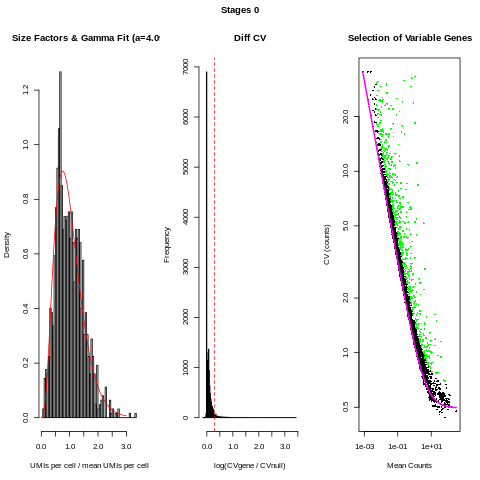

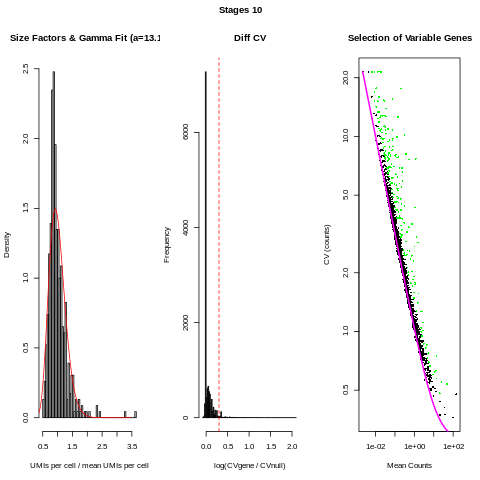

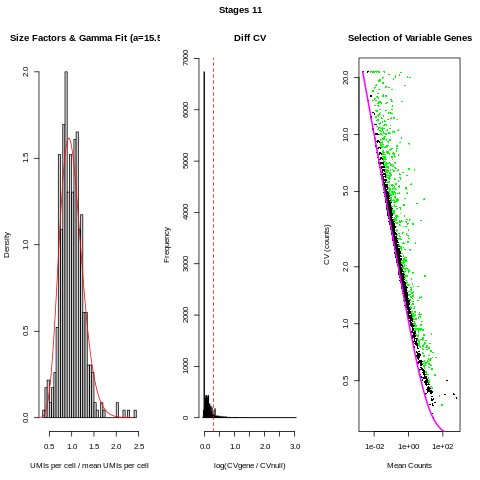

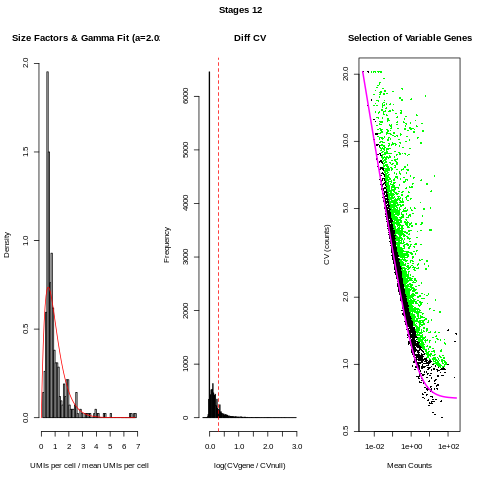

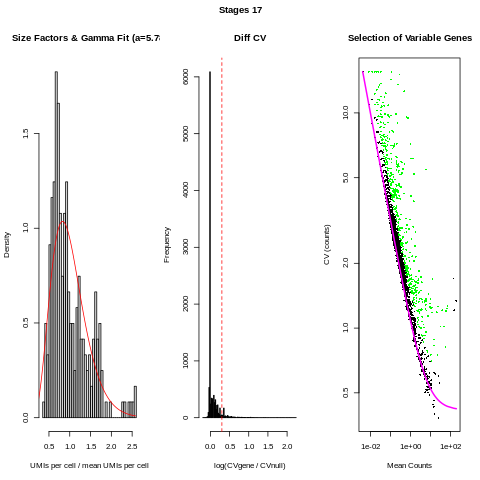

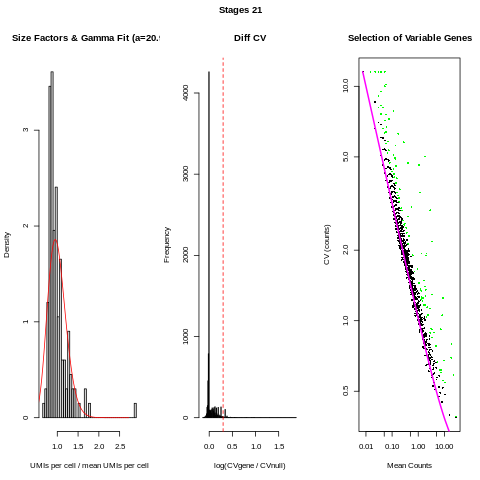

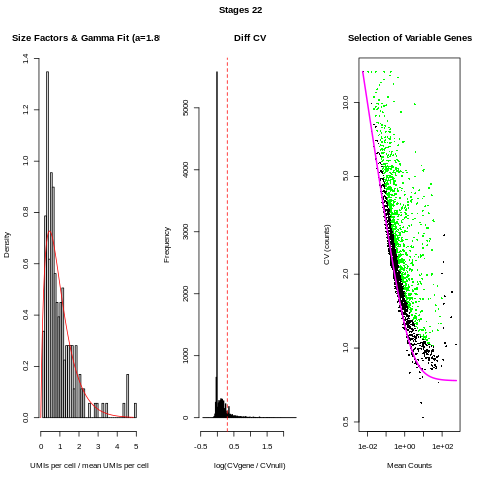

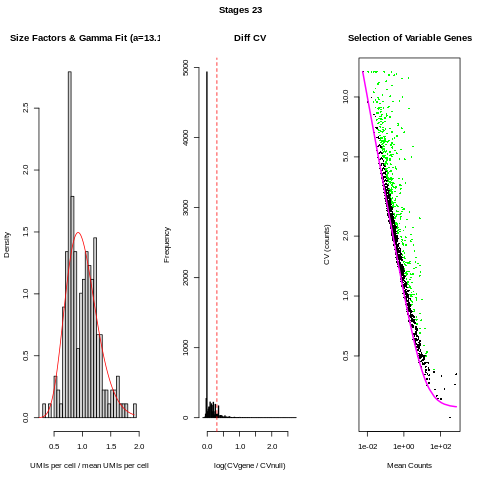

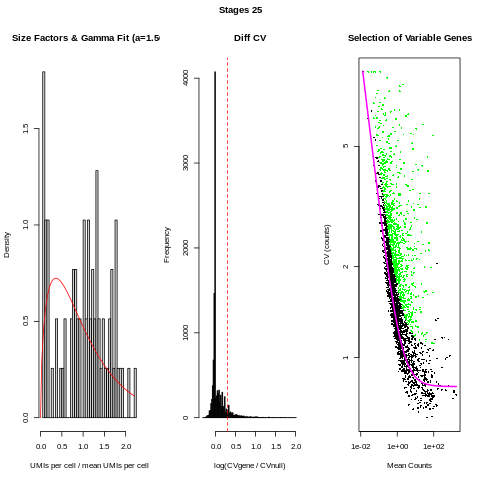

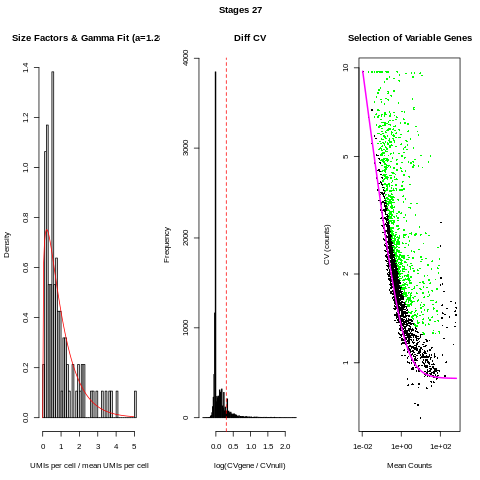

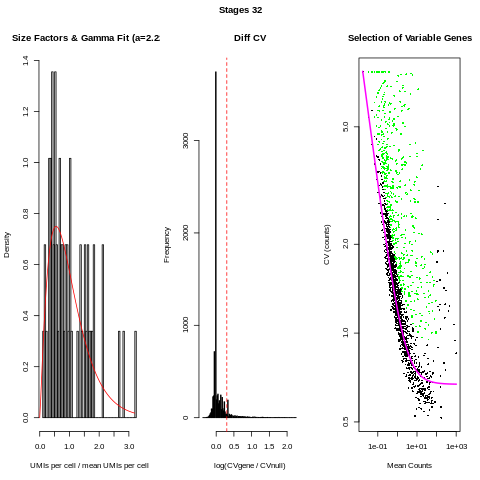

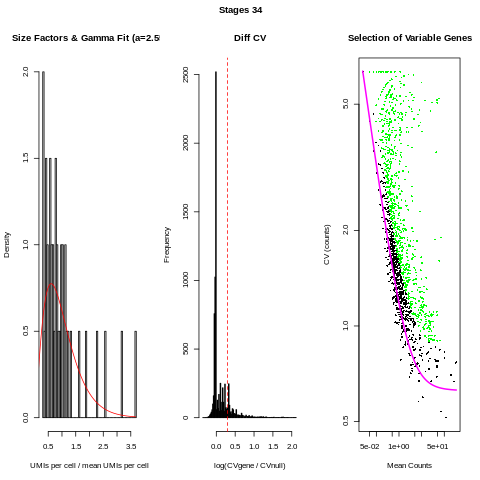

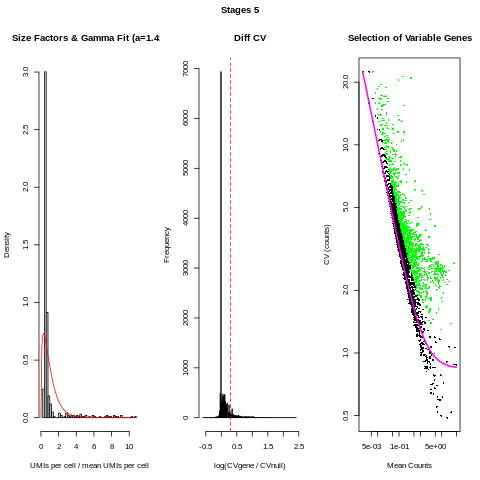

In [ ]:
%%R
# Copy stage from @meta to @group.ids 
lin@group.ids$stage <- as.character(lin@meta[rownames(lin@group.ids),"cluster"])

# Get variable genes for each group of stages
# diffCV.cutoff can be varied to include more or fewer genes.
stages <- sort(unique(lin@group.ids$stage))
var.by.stage <- lapply(seq(length(stages)), function(n) {
  findVariableGenes(lin, cells.fit=cellsInCluster(lin, "stage", stages[n]), set.object.var.genes=F, diffCV.cutoff=0.3, mean.min=.005, mean.max=100, main.use=paste0("Stages ", stages[n]), do.plot=T)
})

In [ ]:
%%R
# Combine the results from each group of stages into a single list of variable genes and load into the URD object
var.genes <- sort(unique(unlist(var.by.stage)))
lin@var.genes <- var.genes

[1] "2021-04-14 21:04:25: Centering and scaling data."
[1] "2021-04-14 21:04:29: Removing genes with no variation."
[1] "2021-04-14 21:04:31: Calculating PCA."
[1] "2021-04-14 21:05:45: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 4.24988050732263"
[1] "22 PCs have eigenvalues larger than 2 times null upper bound."
[1] "Storing 44 PCs."


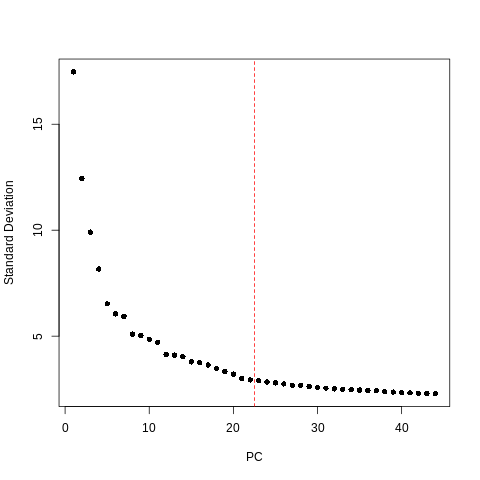

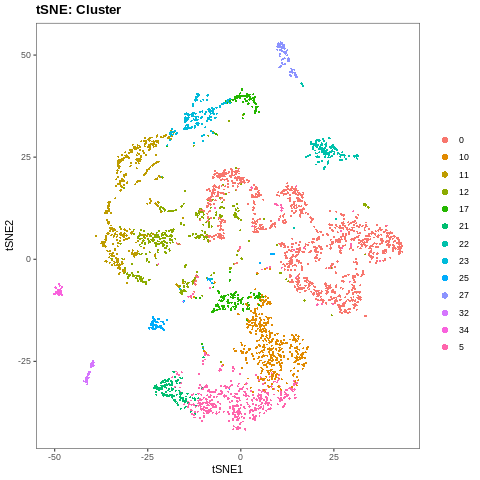

In [ ]:
%%R
# Calculate PCA and consider those PCs that with standard deviation 2x expected by noise as significant
lin <- calcPCA(lin, mp.factor = 2)
pcSDPlot(lin)

# Calculate tSNE
set.seed(42)
lin <- calcTsne(object = lin)
plotDim(lin, "name", plot.title = "tSNE: Cell Type")
plotDim(lin, "stage", plot.title = "tSNE: Cluster")

[1] "destiny determined an optimal global sigma of 26.607"


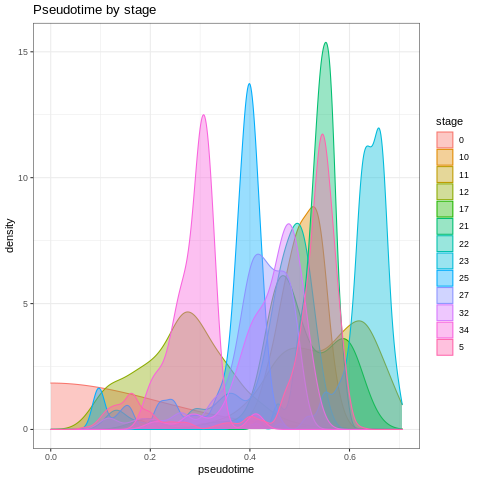

In [ ]:
%%R
# In this case, knn=100 (larger than sqrt(n.cells)) works well because there are not many cell types.
# Sigma 16 is slightly smaller than the sigma auto-determined by using NULL parameter.
lin <- calcDM(lin, knn = 60)
# Here we use all cells from the first stage as the root
root.cells <- cellsInCluster(lin, "stage", "0")

# Then we run 'flood' simulations
lin.floods <- floodPseudotime(lin, root.cells = root.cells, n=50, minimum.cells.flooded = 2, verbose=F)

# The we process the simulations into a pseudotime
lin <- floodPseudotimeProcess(lin, lin.floods, floods.name="pseudotime")

pseudotimePlotStabilityOverall(lin)

plotDists(lin, "pseudotime", "stage", plot.title="Pseudotime by stage")

[1] "2021-04-14 21:14:25: Centering and scaling data."
[1] "2021-04-14 21:14:26: Removing genes with no variation."
[1] "2021-04-14 21:14:26: Calculating PCA."
[1] "2021-04-14 21:14:33: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 7.7003964268589"
[1] "20 PCs have eigenvalues larger than 1.5 times null upper bound."
[1] "Storing 40 PCs."


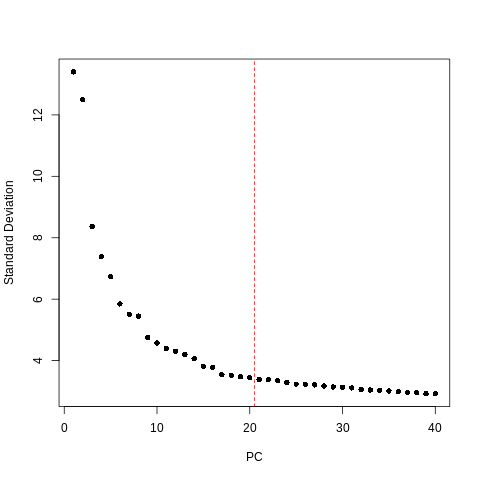

In [ ]:
%%R
# Create a subsetted object of just those cells from the final stage
lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c(10,21,17,23,27,25,32,34,22)))

# Use the variable genes that were calculated only on the final group of stages (which
# contain the last stage).
#lin.tips@var.genes <- var.by.stage[[4]]

# Calculate PCA and tSNE
lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
pcSDPlot(lin.tips)

[1] "Mean pseudotime back (~40 cells) 0.00679677906347431"
[1] "Chance of accepted move to equal pseudotime is 0.821147107520212"
[1] "Mean pseudotime forward (~20 cells) -0.00341655011035028"


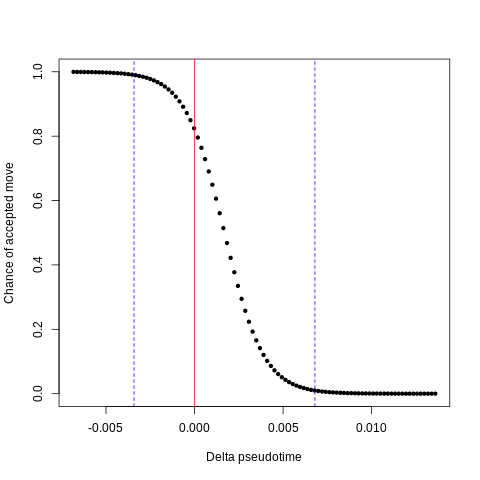

In [ ]:
%%R
# Calculate graph clustering of these cells
lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$stage

# Determine the parameters of the logistic used to bias the transition probabilities. The procedure
# is relatively robust to this parameter, but the cell numbers may need to be modified for larger
# or smaller data sets.
lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=20, max.cells.back=40, do.plot = T)

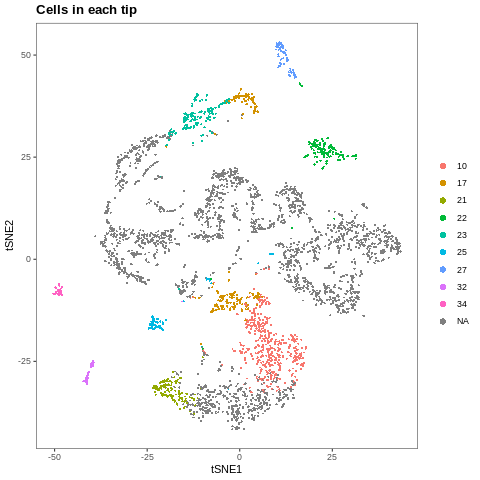

In [ ]:
%%R
# Bias the transition matrix acording to pseudotime
lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# Simulate the biased random walks from each tip
lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm, n.per.tip = 25000, root.visits = 1, max.steps = 5000, verbose = F)

# Process the biased random walks into visitation frequencies
lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

#Plot tips
plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


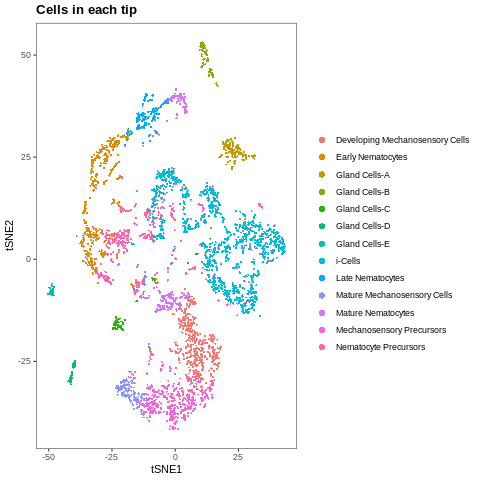

In [ ]:
%%R
plotDim(lin, "name", plot.title="Cells in each tip")

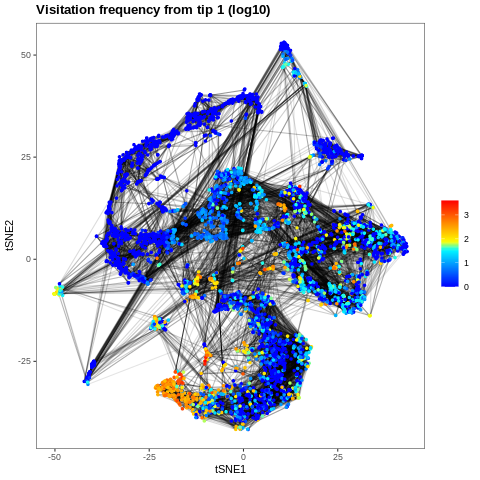

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.21", plot.title="Visitation frequency from tip 1 (log10)", transitions.plot=10000)



In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "16", "5", new.tip = "16")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("23","27","25","32","34","22") , divergence.method = "preference", cells.per.pseudotime.bin = 25, bins.per.pseudotime.window = 8, save.all.breakpoint.info = T, p.thresh=0.001)

[1] "Calculating divergence between 23 and 27 (Pseudotime 0 to 0.499)"


R[write to console]: Difference between 23 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 25 (Pseudotime 0 to 0.454)"
[1] "Calculating divergence between 23 and 32 (Pseudotime 0 to 0.521)"


R[write to console]: Difference between 23 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 34 (Pseudotime 0 to 0.412)"


R[write to console]: Difference between 23 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 22 (Pseudotime 0 to 0.552)"
[1] "Calculating divergence between 27 and 25 (Pseudotime 0 to 0.454)"


R[write to console]: Difference between 27 and 25 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.499)"
[1] "Calculating divergence between 27 and 34 (Pseudotime 0 to 0.412)"


R[write to console]: Difference between 27 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.499)"
[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.454)"
[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.412)"


R[write to console]: Difference between 25 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.454)"
[1] "Calculating divergence between 32 and 34 (Pseudotime 0 to 0.412)"


R[write to console]: Difference between 32 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.521)"
[1] "Calculating divergence between 34 and 22 (Pseudotime 0 to 0.412)"
[1] "Joining segments 27 and 32 at pseudotime 0.25 to create segment 35"
[1] "Calculating divergence between 23 and 35 (Pseudotime 0 to 0.25)"


R[write to console]: Difference between 23 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.25)"
[1] "Calculating divergence between 34 and 35 (Pseudotime 0 to 0.25)"
[1] "Calculating divergence between 22 and 35 (Pseudotime 0 to 0.25)"


R[write to console]: Difference between 22 and 35 always FALSE -- setting breakpoint to end.



[1] "Joining segments 22 and 35 at pseudotime 0.242 to create segment 36"
[1] "Calculating divergence between 23 and 36 (Pseudotime 0 to 0.242)"


R[write to console]: Difference between 23 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 36 (Pseudotime 0 to 0.242)"
[1] "Calculating divergence between 34 and 36 (Pseudotime 0 to 0.242)"
[1] "Joining segments 23 and 25 at pseudotime 0.042 to create segment 37"
[1] "Calculating divergence between 34 and 37 (Pseudotime 0 to 0.042)"
[1] "Calculating divergence between 36 and 37 (Pseudotime 0 to 0.042)"
[1] "Joining segments 34 and 36 at pseudotime 0.013 to create segment 38"
[1] "Calculating divergence between 37 and 38 (Pseudotime 0 to 0.013)"
[1] "Joining segments 37 and 38 at pseudotime 0 to create segment 39"
[1] "Assigning cells to segments."
[1] "Collapsing short segments."
[1] "Removing singleton segments."
[1] "Reassigning cells to segments."
[1] "Assigning cells to nodes."
[1] "Laying out tree."
[1] "Adding cells to tree."


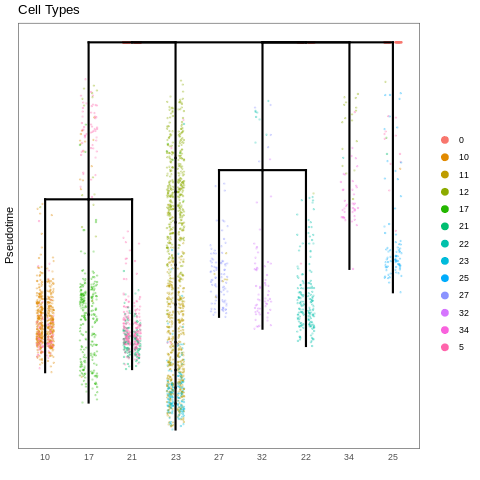

In [ ]:
%%R
#c("10","21","17","23","27","25","32","34","22")
plotTree(lin.tree, "stage", title="Cell Types")

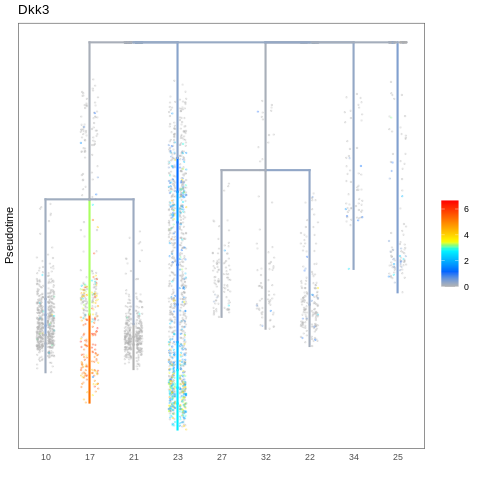

In [ ]:
%%R
#c("10","21","17","23","27","25","32","34","22")
plotTree(lin.tree, "XLOC_030068", title="Dkk3")

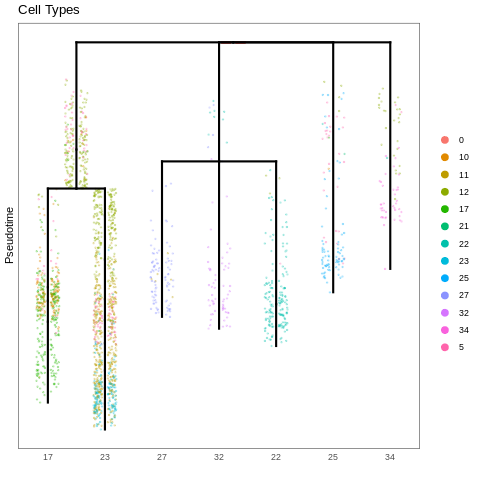

In [ ]:
%%R
#c("17","23","27","25","32","34","22")
plotTree(lin.tree, "stage", title="Cell Types")

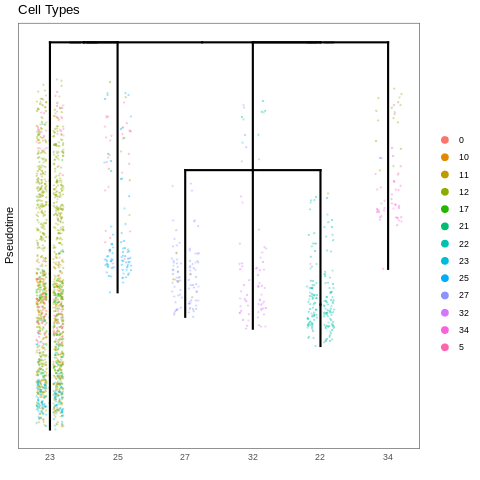

In [ ]:
%%R
#c("23","27","25","32","34","22")
plotTree(lin.tree, "stage", title="Cell Types")

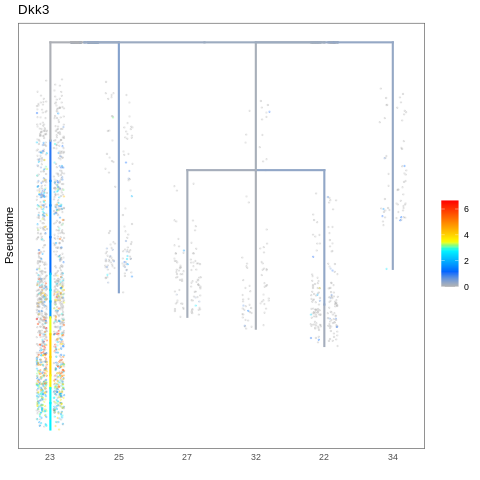

In [ ]:
%%R
#c("23","27","25","32","34","22")
plotTree(lin.tree, "XLOC_030068", title="Dkk3")

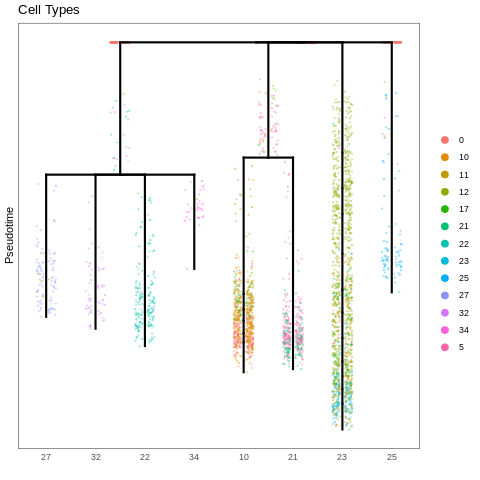

In [ ]:
%%R
plotTree(lin.tree, "stage", title="Cell Types")

##### **Test with no cluster 17 (ambiguous)**

In [ ]:
%%R
# Create an URD object, which will filter the data, then normalize and log-transform it.
lin <- createURD(count.data = subDF, meta = subMeta, min.cells=3, min.counts=3)
lin

R[write to console]: 2021-04-13 17:53:59: Filtering cells by number of genes.

R[write to console]: 2021-04-13 17:54:09: Filtering genes by number of cells.

R[write to console]: 2021-04-13 17:54:21: Filtering genes by number of counts across entire data.

R[write to console]: 2021-04-13 17:54:30: Filtering genes by maximum observed expression.

R[write to console]: 2021-04-13 17:54:39: Creating URD object.

R[write to console]: 2021-04-13 17:54:41: Determining normalization factors.

R[write to console]: 2021-04-13 17:54:43: Normalizing and log-transforming the data.

R[write to console]: 2021-04-13 17:54:53: Finishing setup of the URD object.

R[write to console]: 2021-04-13 17:54:56: All done.



URD object: 16447 genes x 3851 cells.


In [ ]:
%%R
# Copy stage from @meta to @group.ids 
lin@group.ids$stage <- as.character(lin@meta[rownames(lin@group.ids),"cluster"])

# Get variable genes for each group of stages
# diffCV.cutoff can be varied to include more or fewer genes.
stages <- sort(unique(lin@group.ids$stage))
var.by.stage <- lapply(seq(length(stages)), function(n) {
  findVariableGenes(lin, cells.fit=cellsInCluster(lin, "stage", stages[n]), set.object.var.genes=F, diffCV.cutoff=0.3, mean.min=.005, mean.max=100, main.use=paste0("Stages ", stages[n]), do.plot=F)
})

In [ ]:
%%R
# Combine the results from each group of stages into a single list of variable genes and load into the URD object
var.genes <- sort(unique(unlist(var.by.stage)))
lin@var.genes <- var.genes

[1] "2021-04-13 17:55:10: Centering and scaling data."
[1] "2021-04-13 17:55:14: Removing genes with no variation."
[1] "2021-04-13 17:55:15: Calculating PCA."
[1] "2021-04-13 17:56:13: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 4.30947770919417"
[1] "21 PCs have eigenvalues larger than 2 times null upper bound."
[1] "Storing 42 PCs."


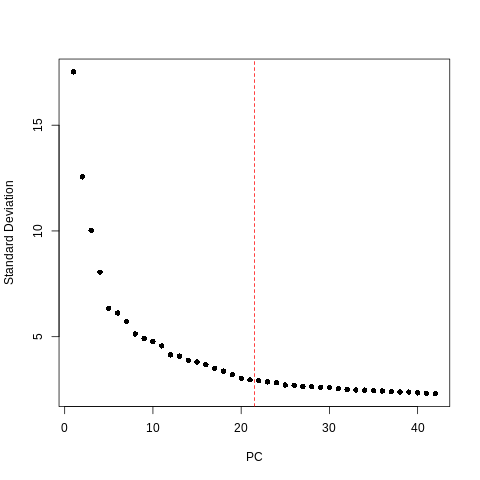

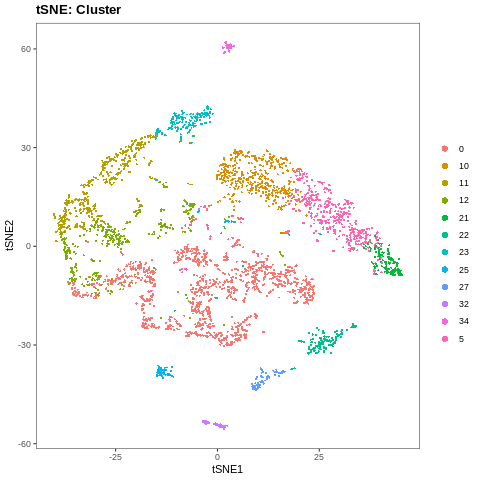

In [ ]:
%%R
# Calculate PCA and consider those PCs that with standard deviation 2x expected by noise as significant
lin <- calcPCA(lin, mp.factor = 2)
pcSDPlot(lin)

# Calculate tSNE
set.seed(42)
lin <- calcTsne(object = lin)
plotDim(lin, "stage", plot.title = "tSNE: Cluster")

[1] "destiny determined an optimal global sigma of 26.519"


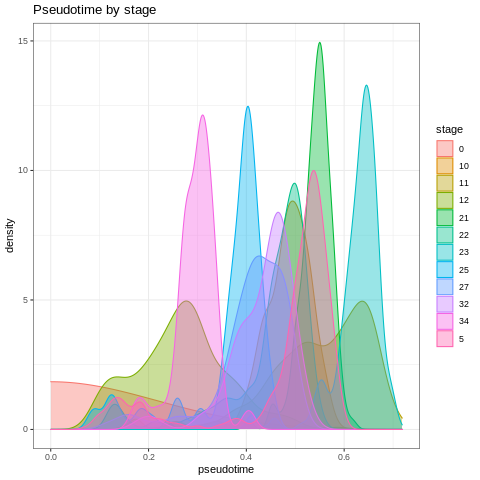

In [ ]:
%%R
# In this case, knn=100 (larger than sqrt(n.cells)) works well because there are not many cell types.
# Sigma 16 is slightly smaller than the sigma auto-determined by using NULL parameter.
lin <- calcDM(lin, knn = 60)
# Here we use all cells from the first stage as the root
root.cells <- cellsInCluster(lin, "stage", "0")

# Then we run 'flood' simulations
lin.floods <- floodPseudotime(lin, root.cells = root.cells, n=50, minimum.cells.flooded = 2, verbose=F)

# The we process the simulations into a pseudotime
lin <- floodPseudotimeProcess(lin, lin.floods, floods.name="pseudotime")

pseudotimePlotStabilityOverall(lin)

plotDists(lin, "pseudotime", "stage", plot.title="Pseudotime by stage")

[1] "2021-04-13 18:03:31: Centering and scaling data."
[1] "2021-04-13 18:03:31: Removing genes with no variation."
[1] "2021-04-13 18:03:32: Calculating PCA."
[1] "2021-04-13 18:03:36: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 8.46519237737338"
[1] "18 PCs have eigenvalues larger than 1.5 times null upper bound."
[1] "Storing 36 PCs."


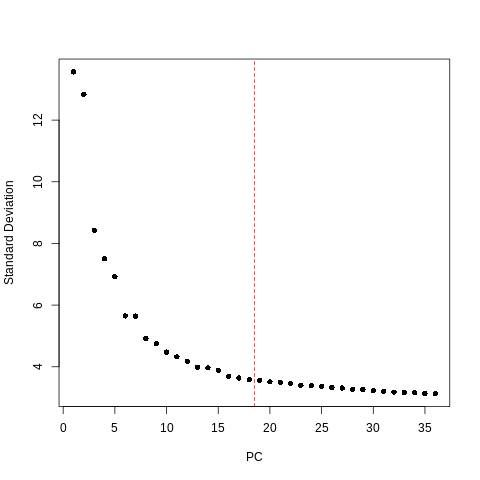

In [ ]:
%%R
# Create a subsetted object of just those cells from the final stage
lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c(10,21,23,27,25,32,34,22)))

# Use the variable genes that were calculated only on the final group of stages (which
# contain the last stage).
#lin.tips@var.genes <- var.by.stage[[4]]

# Calculate PCA and tSNE
lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
pcSDPlot(lin.tips)

[1] "Mean pseudotime back (~40 cells) 0.00719577996988755"
[1] "Chance of accepted move to equal pseudotime is 0.819985427855967"
[1] "Mean pseudotime forward (~20 cells) -0.00363105336609759"


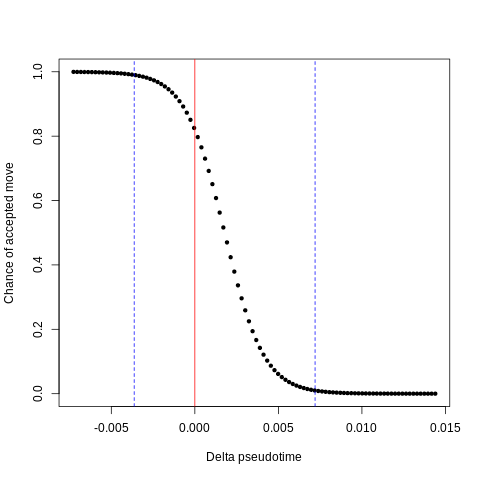

In [ ]:
%%R
# Calculate graph clustering of these cells
#lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$stage

# Determine the parameters of the logistic used to bias the transition probabilities. The procedure
# is relatively robust to this parameter, but the cell numbers may need to be modified for larger
# or smaller data sets.
lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=20, max.cells.back=40, do.plot = T)

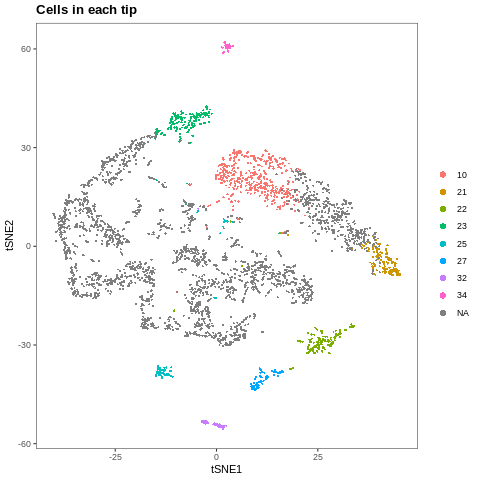

In [ ]:
%%R
# Bias the transition matrix acording to pseudotime
lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# Simulate the biased random walks from each tip
lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm, n.per.tip = 25000, root.visits = 1, max.steps = 5000, verbose = F)

# Process the biased random walks into visitation frequencies
lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

#Plot tips
plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


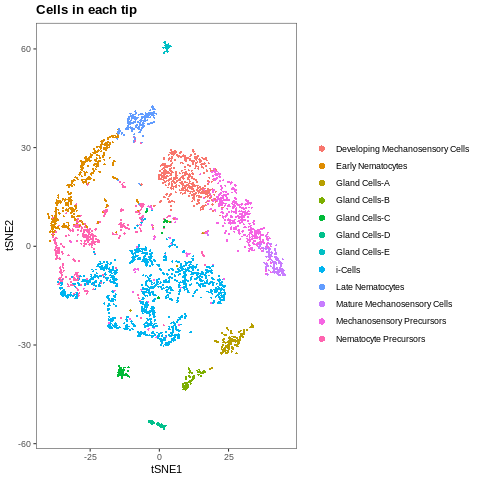

In [ ]:
%%R
plotDim(lin, "name", plot.title="Cells in each tip")

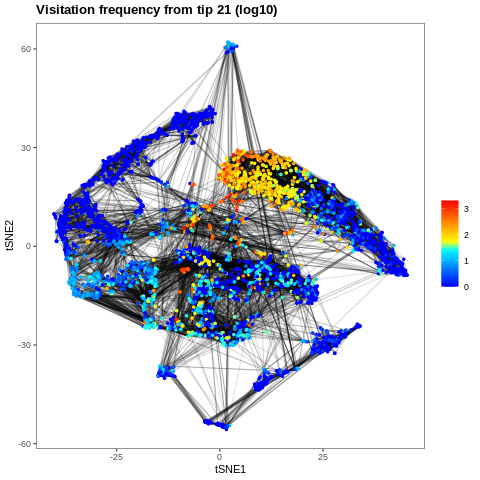

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.10", plot.title="Visitation frequency from tip 21 (log10)", transitions.plot=10000)



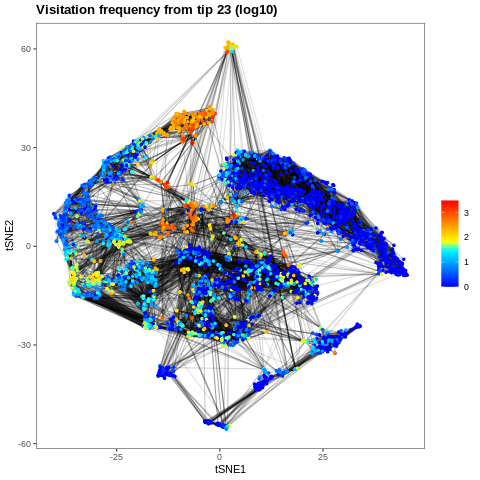

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.23", plot.title="Visitation frequency from tip 23 (log10)", transitions.plot=10000)


In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "16", "5", new.tip = "16")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("21","23","27","25","32","34","22") , divergence.method = "preference", cells.per.pseudotime.bin = 25, bins.per.pseudotime.window = 8, save.all.breakpoint.info = T, p.thresh=0.001)

[1] "Calculating divergence between 21 and 23 (Pseudotime 0 to 0.617)"
[1] "Calculating divergence between 21 and 27 (Pseudotime 0 to 0.51)"


R[write to console]: Difference between 21 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 25 (Pseudotime 0 to 0.456)"
[1] "Calculating divergence between 21 and 32 (Pseudotime 0 to 0.519)"


R[write to console]: Difference between 21 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 22 (Pseudotime 0 to 0.551)"


R[write to console]: Difference between 21 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 27 (Pseudotime 0 to 0.51)"


R[write to console]: Difference between 23 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 25 (Pseudotime 0 to 0.456)"
[1] "Calculating divergence between 23 and 32 (Pseudotime 0 to 0.519)"


R[write to console]: Difference between 23 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 23 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 22 (Pseudotime 0 to 0.551)"
[1] "Calculating divergence between 27 and 25 (Pseudotime 0 to 0.456)"


R[write to console]: Difference between 27 and 25 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.51)"
[1] "Calculating divergence between 27 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 27 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.51)"
[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.456)"


R[write to console]: Difference between 25 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 25 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.456)"


R[write to console]: Difference between 25 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 32 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.519)"


R[write to console]: Difference between 32 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 22 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 34 and 22 always FALSE -- setting breakpoint to end.



[1] "Joining segments 34 and 22 at pseudotime 0.344 to create segment 35"
[1] "Calculating divergence between 21 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 35 (Pseudotime 0 to 0.344)"
[1] "Calculating divergence between 27 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 27 and 35 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 25 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 32 and 35 always FALSE -- setting breakpoint to end.



[1] "Joining segments 27 and 35 at pseudotime 0.344 to create segment 36"
[1] "Calculating divergence between 21 and 36 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 36 (Pseudotime 0 to 0.344)"
[1] "Calculating divergence between 25 and 36 (Pseudotime 0 to 0.344)"
[1] "Calculating divergence between 32 and 36 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 32 and 36 always FALSE -- setting breakpoint to end.



[1] "Joining segments 32 and 36 at pseudotime 0.344 to create segment 37"
[1] "Calculating divergence between 21 and 37 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 37 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 37 (Pseudotime 0 to 0.344)"
[1] "Calculating divergence between 25 and 37 (Pseudotime 0 to 0.344)"
[1] "Joining segments 21 and 25 at pseudotime 0.061 to create segment 38"
[1] "Calculating divergence between 23 and 38 (Pseudotime 0 to 0.061)"


R[write to console]: Difference between 23 and 38 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 37 and 38 (Pseudotime 0 to 0.061)"
[1] "Joining segments 23 and 37 at pseudotime 0 to create segment 39"
[1] "Calculating divergence between 38 and 39 (Pseudotime 0 to 0)"
[1] "Joining segments 38 and 39 at pseudotime 0 to create segment 40"
[1] "Assigning cells to segments."
[1] "Collapsing short segments."
[1] "Removing singleton segments."
[1] "Reassigning cells to segments."
[1] "Assigning cells to nodes."
[1] "Laying out tree."
[1] "Adding cells to tree."


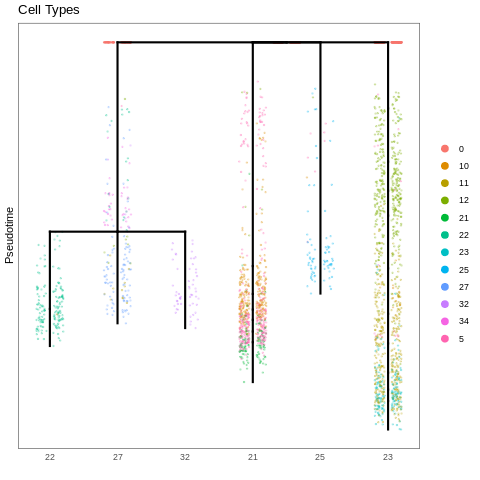

In [ ]:
%%R
plotTree(lin.tree, "stage", title="Cell Types")

In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "16", "5", new.tip = "16")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("10","21","23","27","25","32","34","22") , divergence.method = "preference", cells.per.pseudotime.bin = 25, bins.per.pseudotime.window = 8, save.all.breakpoint.info = T, p.thresh=0.001)

[1] "Calculating divergence between 10 and 21 (Pseudotime 0 to 0.59)"
[1] "Calculating divergence between 10 and 23 (Pseudotime 0 to 0.59)"
[1] "Calculating divergence between 10 and 27 (Pseudotime 0 to 0.51)"


R[write to console]: Difference between 10 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 10 and 25 (Pseudotime 0 to 0.456)"


R[write to console]: Difference between 10 and 25 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 10 and 32 (Pseudotime 0 to 0.519)"


R[write to console]: Difference between 10 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 10 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 10 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 10 and 22 (Pseudotime 0 to 0.551)"


R[write to console]: Difference between 10 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 23 (Pseudotime 0 to 0.617)"
[1] "Calculating divergence between 21 and 27 (Pseudotime 0 to 0.51)"


R[write to console]: Difference between 21 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 25 (Pseudotime 0 to 0.456)"
[1] "Calculating divergence between 21 and 32 (Pseudotime 0 to 0.519)"


R[write to console]: Difference between 21 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 22 (Pseudotime 0 to 0.551)"


R[write to console]: Difference between 21 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 27 (Pseudotime 0 to 0.51)"


R[write to console]: Difference between 23 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 25 (Pseudotime 0 to 0.456)"
[1] "Calculating divergence between 23 and 32 (Pseudotime 0 to 0.519)"


R[write to console]: Difference between 23 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 23 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 22 (Pseudotime 0 to 0.551)"
[1] "Calculating divergence between 27 and 25 (Pseudotime 0 to 0.456)"


R[write to console]: Difference between 27 and 25 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.51)"
[1] "Calculating divergence between 27 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 27 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.51)"
[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.456)"


R[write to console]: Difference between 25 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 25 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.456)"


R[write to console]: Difference between 25 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 34 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 32 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.519)"


R[write to console]: Difference between 32 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 22 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 34 and 22 always FALSE -- setting breakpoint to end.



[1] "Joining segments 34 and 22 at pseudotime 0.344 to create segment 35"
[1] "Calculating divergence between 10 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 10 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 35 (Pseudotime 0 to 0.344)"
[1] "Calculating divergence between 27 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 27 and 35 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 25 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 35 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 32 and 35 always FALSE -- setting breakpoint to end.



[1] "Joining segments 27 and 35 at pseudotime 0.344 to create segment 36"
[1] "Calculating divergence between 10 and 36 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 10 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 36 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 36 (Pseudotime 0 to 0.344)"
[1] "Calculating divergence between 25 and 36 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 25 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 36 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 32 and 36 always FALSE -- setting breakpoint to end.



[1] "Joining segments 32 and 36 at pseudotime 0.344 to create segment 37"
[1] "Calculating divergence between 10 and 37 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 10 and 37 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 37 (Pseudotime 0 to 0.344)"


R[write to console]: Difference between 21 and 37 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 37 (Pseudotime 0 to 0.344)"
[1] "Calculating divergence between 25 and 37 (Pseudotime 0 to 0.344)"
[1] "Joining segments 10 and 21 at pseudotime 0.25 to create segment 38"
[1] "Calculating divergence between 23 and 38 (Pseudotime 0 to 0.25)"
[1] "Calculating divergence between 25 and 38 (Pseudotime 0 to 0.25)"
[1] "Calculating divergence between 37 and 38 (Pseudotime 0 to 0.25)"


R[write to console]: Difference between 37 and 38 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 23 and 25 at pseudotime 0.001 to create segment 39"
[1] "Calculating divergence between 37 and 39 (Pseudotime 0 to 0.001)"
[1] "Calculating divergence between 38 and 39 (Pseudotime 0 to 0.001)"
[1] "Joining segments 37 and 38 at pseudotime 0 to create segment 40"
[1] "Calculating divergence between 39 and 40 (Pseudotime 0 to 0)"


R[write to console]: Difference between 39 and 40 always FALSE -- setting breakpoint to end.



[1] "Joining segments 39 and 40 at pseudotime 0 to create segment 41"
[1] "Assigning cells to segments."
[1] "Collapsing short segments."
[1] "Removing singleton segments."
[1] "Reassigning cells to segments."
[1] "Assigning cells to nodes."
[1] "Laying out tree."
[1] "Adding cells to tree."


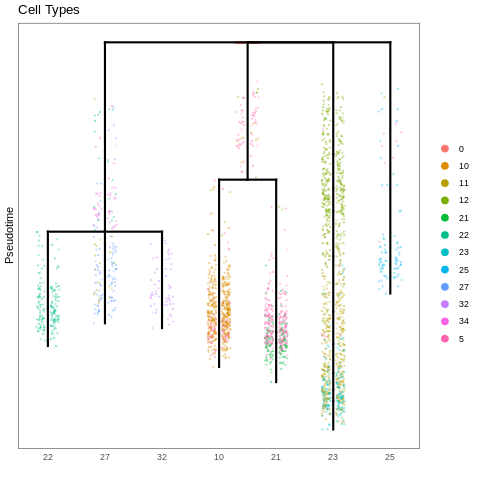

In [ ]:
%%R
#With 10
plotTree(lin.tree, "stage", title="Cell Types")

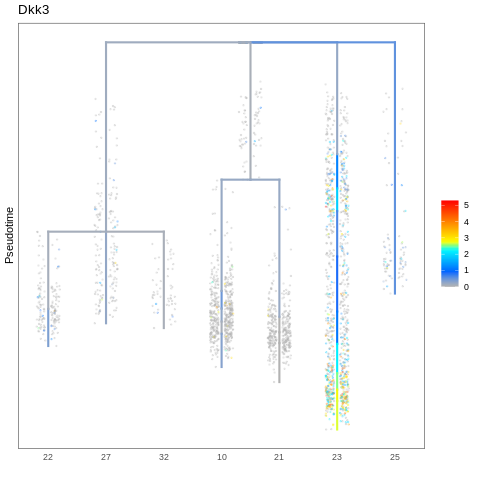

In [ ]:
%%R
#With 10
plotTree(lin.tree, "XLOC_030068", title="Dkk3")

##### **Generate Tree for i-Cell Derived Cell Types**

In [ ]:
%%R
neurDF <- t(as.matrix(readMM("neurLineage.mtx")))

genes <- read.table("neurGenes.csv", header = TRUE, sep = ",")
neurMeta <- read.table("neurLinMeta.csv", header = TRUE, sep = ",")

rownames(neurDF) <- genes$genes
colnames(neurDF) <- neurMeta$index

rownames(neurMeta) <- neurMeta$index

#Test removing unknown cluster 17
subMeta <- neurMeta[neurMeta$cluster != 17,]  
subDF <- neurDF[,subMeta$index]

head(subMeta)

# Create an URD object, which will filter the data, then normalize and log-transform it.
lin <- createURD(count.data = neurDF, meta = neurMeta, min.cells=1, min.counts=1, max.genes.in.ram = 100)
lin

R[write to console]: 2021-04-21 21:28:22: Filtering cells by number of genes.

R[write to console]: 2021-04-21 21:28:47: Filtering genes by number of cells.

R[write to console]: 2021-04-21 21:29:03: Filtering genes by number of counts across entire data.

R[write to console]: 2021-04-21 21:29:17: Filtering genes by maximum observed expression.

R[write to console]: 2021-04-21 21:29:30: Creating URD object.

R[write to console]: 2021-04-21 21:29:32: Determining normalization factors.

R[write to console]: 2021-04-21 21:29:36: Normalizing and log-transforming the data.

R[write to console]: 2021-04-21 21:30:16: Finishing setup of the URD object.

R[write to console]: 2021-04-21 21:30:20: All done.



URD object: 20674 genes x 4914 cells.


In [ ]:
%%R
# Copy stage from @meta to @group.ids 
lin@group.ids$stage <- as.character(lin@meta[rownames(lin@group.ids),"cluster"])

# Get variable genes for each group of stages
# diffCV.cutoff can be varied to include more or fewer genes.
stages <- sort(unique(lin@group.ids$stage))
var.by.stage <- lapply(seq(length(stages)), function(n) {
  findVariableGenes(lin, cells.fit=cellsInCluster(lin, "stage", stages[n]), set.object.var.genes=F, diffCV.cutoff=0.3, mean.min=.005, mean.max=100, main.use=paste0("Stages ", stages[n]), do.plot=F)
})

In [ ]:
%%R
# Combine the results from each group of stages into a single list of variable genes and load into the URD object
var.genes <- sort(unique(unlist(var.by.stage)))
lin@var.genes <- var.genes

[1] "2021-04-21 21:30:38: Centering and scaling data."
[1] "2021-04-21 21:30:44: Removing genes with no variation."
[1] "2021-04-21 21:30:45: Calculating PCA."
[1] "2021-04-21 21:33:00: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 4.19149360252537"
[1] "32 PCs have eigenvalues larger than 2 times null upper bound."
[1] "Storing 64 PCs."


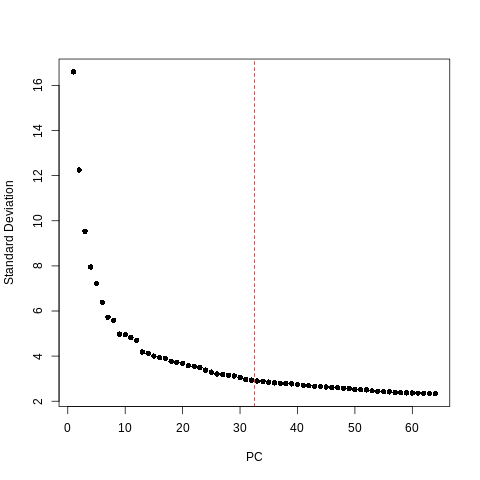

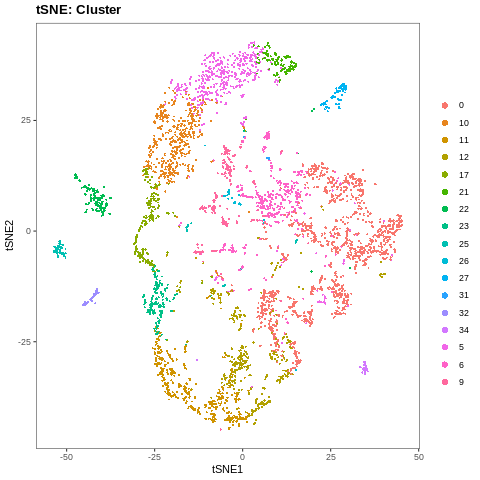

In [ ]:
%%R
# Calculate PCA and consider those PCs that with standard deviation 2x expected by noise as significant
lin <- calcPCA(lin, mp.factor = 2)
pcSDPlot(lin)

# Calculate tSNE
set.seed(42)
lin <- calcTsne(object = lin)
plotDim(lin, "stage", plot.title = "tSNE: Cluster")

[1] "destiny determined an optimal global sigma of 29.178"


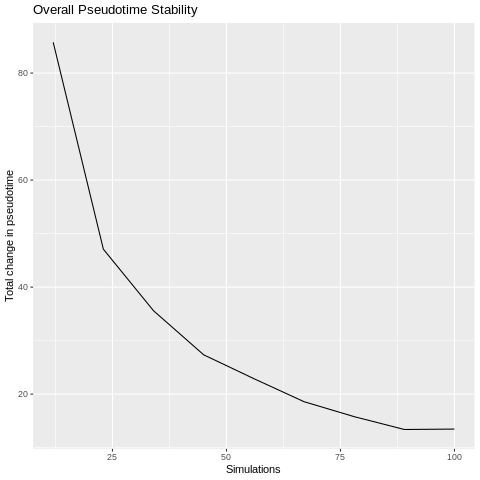

In [ ]:
%%R
# In this case, knn=100 (larger than sqrt(n.cells)) works well because there are not many cell types.
# Sigma 16 is slightly smaller than the sigma auto-determined by using NULL parameter.
lin <- calcDM(lin, knn = 60)
# Here we use all cells from the first stage as the root
root.cells <- cellsInCluster(lin, "stage", "0")

# Then we run 'flood' simulations
lin.floods <- floodPseudotime(lin, root.cells = root.cells, n=100, minimum.cells.flooded = 2, verbose=F)

# The we process the simulations into a pseudotime
lin <- floodPseudotimeProcess(lin, lin.floods, floods.name="pseudotime")

pseudotimePlotStabilityOverall(lin)



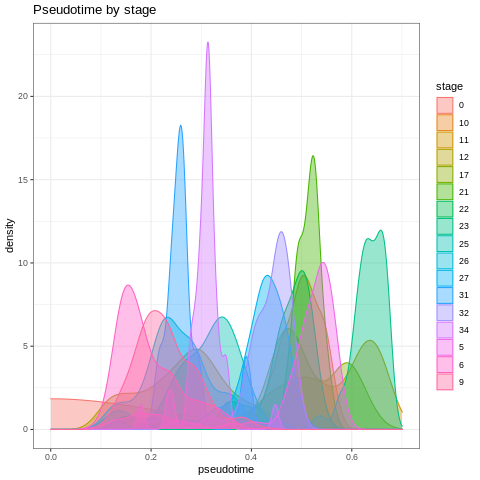

In [ ]:
%%R
#Check pseudotime assignments per cell type
plotDists(lin, "pseudotime", "stage", plot.title="Pseudotime by stage")

In [ ]:
%%R
length(lin@var.genes)

[1] 5390


In [ ]:
%%R
sort(unique(lin@group.ids$stage))

 [1] "0"  "10" "11" "12" "17" "21" "22" "23" "25" "26" "27" "31" "32" "34" "5" 
[16] "6"  "9" 


[1] "2021-04-21 22:04:13: Centering and scaling data."
[1] "2021-04-21 22:04:16: Removing genes with no variation."
[1] "2021-04-21 22:04:16: Calculating PCA."
[1] "2021-04-21 22:04:29: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 6.78637897511064"
[1] "28 PCs have eigenvalues larger than 1.5 times null upper bound."
[1] "Storing 56 PCs."


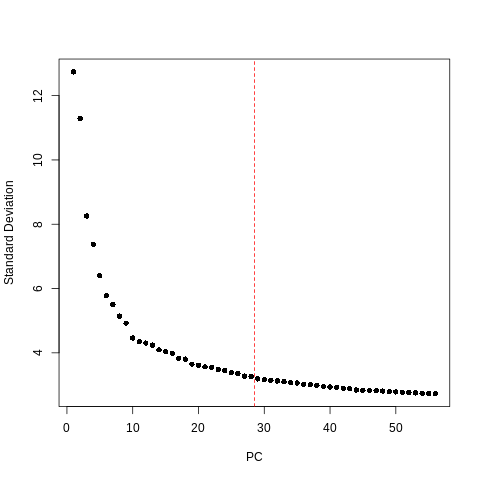

In [ ]:
%%R
# Create a subsetted object of just those cells from the final stage
#Test c(26,31,9,27,25,32,34,22,21, 23) , c(26,31,9,27,25,32,34,22, 23), c(26,31,9,27,25,32,34,22,10, 23)
lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c(26,31,9,27,25,32,34,22, 17,10,21, 23)))

# Use the variable genes that were calculated only on the final group of stages
lin.tips@var.genes <- sort(unique(unlist(var.by.stage[c(2,5,6,7,8,9,10,11,12,13,14,17)]))) #var.by.stage[c(2,5,6,7,8,9,10,11,12,13,14,17)]

# Calculate PCA and tSNE
lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
pcSDPlot(lin.tips)

[1] "Mean pseudotime back (~100 cells) 0.0138909995874002"
[1] "Chance of accepted move to equal pseudotime is 0.99009900990099"
[1] "Mean pseudotime forward (~0 cells) 0"


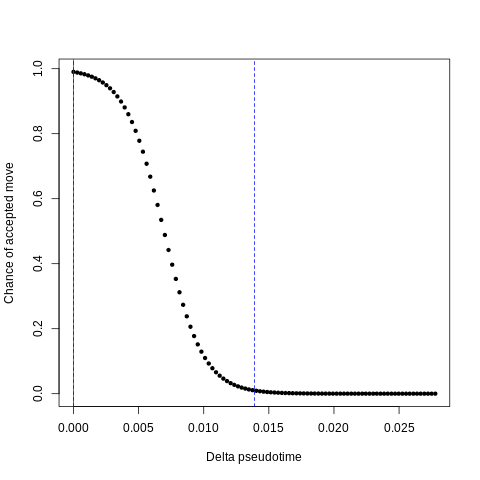

In [ ]:
%%R
# Calculate graph clustering of these cells
#lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$stage

# Determine the parameters of the logistic used to bias the transition probabilities. The procedure
# is relatively robust to this parameter, but the cell numbers may need to be modified for larger
# or smaller data sets.
lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=0, max.cells.back=100, pseudotime.direction = "<", do.plot = T) #20, 40

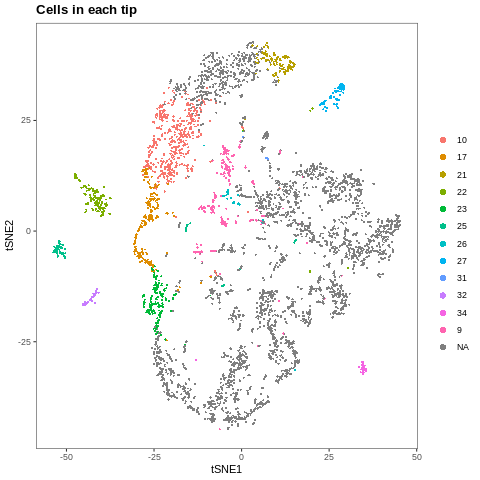

In [ ]:
%%R
# Bias the transition matrix acording to pseudotime
lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# Simulate the biased random walks from each tip
lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm, root.visits = 1, n.per.tip = 20000, max.steps = 5000, verbose = F) #n.per.tip = 500000,

# Process the biased random walks into visitation frequencies
lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

#Plot tips
plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


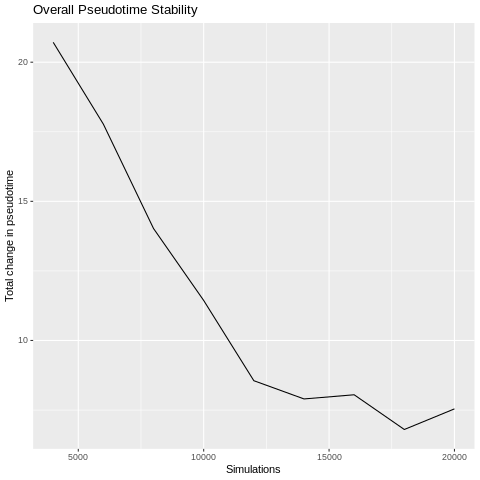

In [ ]:
%%R
pseudotimePlotStabilityOverall(lin)

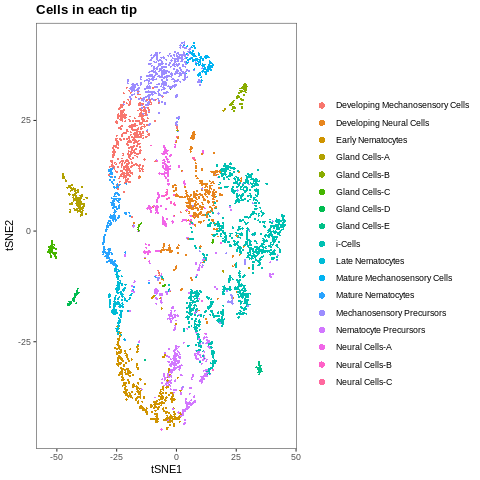

In [ ]:
%%R
plotDim(lin, "name", plot.title="Cells in each tip")

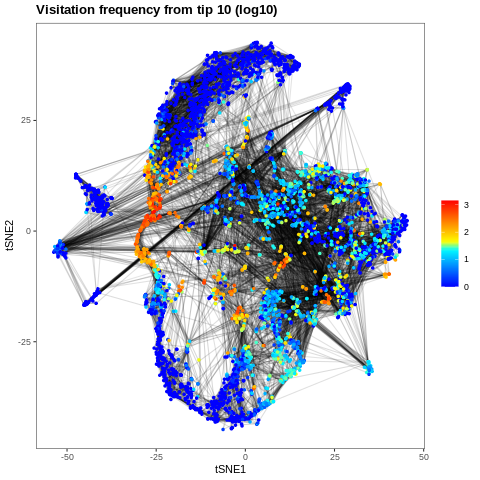

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.17", plot.title="Visitation frequency from tip 10 (log10)", transitions.plot=10000)



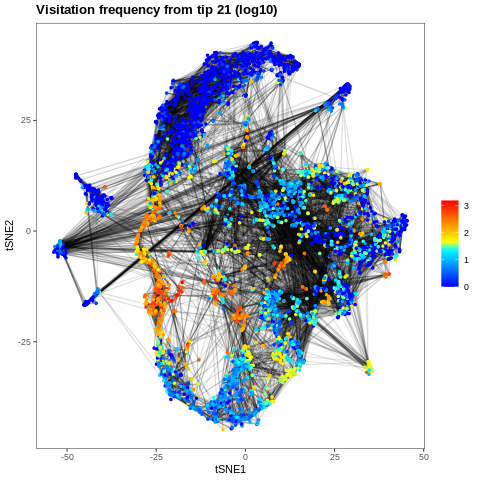

In [ ]:
%%R
#Plot visitation frequencies 
plotDim(lin, "visitfreq.log.23", plot.title="Visitation frequency from tip 21 (log10)", transitions.plot=10000)


Read in data

In [17]:
%%R
lin <- readRDS(file="allNeurLin (1).rds")
lin

URD object: 20674 genes x 4914 cells.


In [ ]:
# %%R
# #TEST NEW CLUSTERING
# # Create a subsetted object of just those cells from the final stage
# #Test c(26,31,9,27,25,32,34,22,21, 23) , c(26,31,9,27,25,32,34,22, 23), c(26,31,9,27,25,32,34,22,10, 23)
# lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c(26,31,9,27,25,32,34,22, 17,10,21, 23)))

# # Use the variable genes that were calculated only on the final group of stages

# #lin.tips@var.genes <- sort(unique(unlist(var.by.stage[c(2,5,6,7,8,9,10,11,12,13,14,17)]))) #var.by.stage[c(2,5,6,7,8,9,10,11,12,13,14,17)]

# # Calculate PCA and tSNE
# lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
# pcSDPlot(lin.tips)

# # Calculate graph clustering of these cells
# lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# # Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
# lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$Louvain

# lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=0, max.cells.back=100, pseudotime.direction = "<", do.plot = T) 

[1] "2021-04-25 22:51:10: Centering and scaling data."
[1] "2021-04-25 22:51:13: Removing genes with no variation."
[1] "2021-04-25 22:51:13: Calculating PCA."


In [ ]:
# %%R
# # Bias the transition matrix acording to pseudotime
# lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# # Simulate the biased random walks from each tip
# lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm, root.visits = 1, n.per.tip = 20000, max.steps = 5000, verbose = F) #n.per.tip = 500000,

# # Process the biased random walks into visitation frequencies
# lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

# #Plot tips
# plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


R[write to console]: Error in current.cell %in% end.cells : object 'root.cells' not found




Error in current.cell %in% end.cells : object 'root.cells' not found


In [24]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
#lin.tree <- combineTipVisitation(lin.tree, "17", "23", new.tip = "80")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
#c("26","31","9","27","25","32","22", "23")
#c("26","31","9","27","25","32","22", "23","21")

#c("26","31","9","27","25","32","22", "17","21")
#c("26","31","9","27","25","32","22", "17")
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("26","31","25","27","32","22","17","10","21","9")  , divergence.method = "preference", cells.per.pseudotime.bin = 25, bins.per.pseudotime.window = 10, save.all.breakpoint.info = T, p.thresh=0.01,save.breakpoint.plots ="breakpoint.pdf") #orig, 25 ,8, p =.001,min.cells.per.segment=10

[1] "Calculating divergence between 26 and 31 (Pseudotime 0 to 0.373)"


R[write to console]: Difference between 26 and 31 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 26 and 25 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 26 and 27 (Pseudotime 0 to 0.373)"


R[write to console]: Difference between 26 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 32 (Pseudotime 0 to 0.373)"


R[write to console]: Difference between 26 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 22 (Pseudotime 0 to 0.373)"


R[write to console]: Difference between 26 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 17 (Pseudotime 0 to 0.373)"


R[write to console]: Difference between 26 and 17 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 10 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 26 and 21 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 26 and 9 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 31 and 25 (Pseudotime 0 to 0.39)"
[1] "Calculating divergence between 31 and 27 (Pseudotime 0 to 0.39)"


R[write to console]: Difference between 31 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 32 (Pseudotime 0 to 0.39)"
[1] "Calculating divergence between 31 and 22 (Pseudotime 0 to 0.39)"
[1] "Calculating divergence between 31 and 17 (Pseudotime 0 to 0.39)"
[1] "Calculating divergence between 31 and 10 (Pseudotime 0 to 0.39)"
[1] "Calculating divergence between 31 and 21 (Pseudotime 0 to 0.39)"
[1] "Calculating divergence between 31 and 9 (Pseudotime 0 to 0.39)"
[1] "Calculating divergence between 25 and 27 (Pseudotime 0 to 0.421)"
[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.421)"
[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.421)"
[1] "Calculating divergence between 25 and 17 (Pseudotime 0 to 0.421)"


R[write to console]: Difference between 25 and 17 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 10 (Pseudotime 0 to 0.421)"


R[write to console]: Difference between 25 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 21 (Pseudotime 0 to 0.421)"
[1] "Calculating divergence between 25 and 9 (Pseudotime 0 to 0.421)"
[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.488)"
[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.504)"
[1] "Calculating divergence between 27 and 17 (Pseudotime 0 to 0.504)"


R[write to console]: Difference between 27 and 17 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 10 (Pseudotime 0 to 0.504)"


R[write to console]: Difference between 27 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 21 (Pseudotime 0 to 0.504)"


R[write to console]: Difference between 27 and 21 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 9 (Pseudotime 0 to 0.432)"


R[write to console]: Difference between 27 and 9 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.488)"
[1] "Calculating divergence between 32 and 17 (Pseudotime 0 to 0.488)"


R[write to console]: Difference between 32 and 17 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 10 (Pseudotime 0 to 0.488)"


R[write to console]: Difference between 32 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 21 (Pseudotime 0 to 0.488)"
[1] "Calculating divergence between 32 and 9 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 22 and 17 (Pseudotime 0 to 0.554)"
[1] "Calculating divergence between 22 and 10 (Pseudotime 0 to 0.554)"
[1] "Calculating divergence between 22 and 21 (Pseudotime 0 to 0.554)"
[1] "Calculating divergence between 22 and 9 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 17 and 10 (Pseudotime 0 to 0.581)"
[1] "Calculating divergence between 17 and 21 (Pseudotime 0 to 0.568)"
[1] "Calculating divergence between 17 and 9 (Pseudotime 0 to 0.432)"


R[write to console]: Difference between 17 and 9 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 10 and 21 (Pseudotime 0 to 0.568)"
[1] "Calculating divergence between 10 and 9 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 21 and 9 (Pseudotime 0 to 0.432)"
[1] "Saving breakpoint decision plot."
[1] "Joining segments 26 and 31 at pseudotime 0.373 to create segment 33"
[1] "Calculating divergence between 25 and 33 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 27 and 33 (Pseudotime 0 to 0.373)"


R[write to console]: Difference between 27 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 33 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 22 and 33 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 17 and 33 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 10 and 33 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 21 and 33 (Pseudotime 0 to 0.373)"
[1] "Calculating divergence between 9 and 33 (Pseudotime 0 to 0.373)"
[1] "Saving breakpoint decision plot."
[1] "Joining segments 27 and 22 at pseudotime 0.31 to create segment 34"
[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 32 and 34 (Pseudotime 0 to 0.31)"


R[write to console]: Difference between 32 and 34 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 17 and 34 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 10 and 34 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 21 and 34 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 9 and 34 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 33 and 34 (Pseudotime 0 to 0.31)"
[1] "Saving breakpoint decision plot."
[1] "Joining segments 32 and 34 at pseudotime 0.31 to create segment 35"
[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 17 and 35 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 10 and 35 (Pseudotime 0 to 0.31)"


R[write to console]: Difference between 10 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 35 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 9 and 35 (Pseudotime 0 to 0.31)"
[1] "Calculating divergence between 33 and 35 (Pseudotime 0 to 0.31)"
[1] "Saving breakpoint decision plot."
[1] "Joining segments 17 and 10 at pseudotime 0.245 to create segment 36"
[1] "Calculating divergence between 25 and 36 (Pseudotime 0 to 0.245)"
[1] "Calculating divergence between 21 and 36 (Pseudotime 0 to 0.245)"


R[write to console]: Difference between 21 and 36 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 9 and 36 (Pseudotime 0 to 0.245)"
[1] "Calculating divergence between 33 and 36 (Pseudotime 0 to 0.245)"
[1] "Calculating divergence between 35 and 36 (Pseudotime 0 to 0.245)"
[1] "Saving breakpoint decision plot."
[1] "Joining segments 21 and 36 at pseudotime 0.245 to create segment 37"
[1] "Calculating divergence between 25 and 37 (Pseudotime 0 to 0.245)"
[1] "Calculating divergence between 9 and 37 (Pseudotime 0 to 0.245)"
[1] "Calculating divergence between 33 and 37 (Pseudotime 0 to 0.245)"
[1] "Calculating divergence between 35 and 37 (Pseudotime 0 to 0.245)"
[1] "Saving breakpoint decision plot."
[1] "Joining segments 25 and 9 at pseudotime 0.217 to create segment 38"
[1] "Calculating divergence between 33 and 38 (Pseudotime 0 to 0.217)"
[1] "Calculating divergence between 35 and 38 (Pseudotime 0 to 0.217)"
[1] "Calculating divergence between 37 and 38 (Pseudotime 0 to 0.217)"
[1] "Saving breakpoint decision plot."
[1] "Joining segments 33 and

R[write to console]: Difference between 37 and 39 always FALSE -- setting breakpoint to end.



[1] "Saving breakpoint decision plot."
[1] "Joining segments 37 and 39 at pseudotime 0.177 to create segment 40"
[1] "Calculating divergence between 35 and 40 (Pseudotime 0 to 0.177)"


R[write to console]: Difference between 35 and 40 always FALSE -- setting breakpoint to end.



[1] "Saving breakpoint decision plot."
[1] "Joining segments 35 and 40 at pseudotime 0.177 to create segment 41"
[1] "Assigning cells to segments."
[1] "Collapsing short segments."
[1] "Removing singleton segments."
[1] "Reassigning cells to segments."
[1] "Assigning cells to nodes."
[1] "Laying out tree."
[1] "Adding cells to tree."


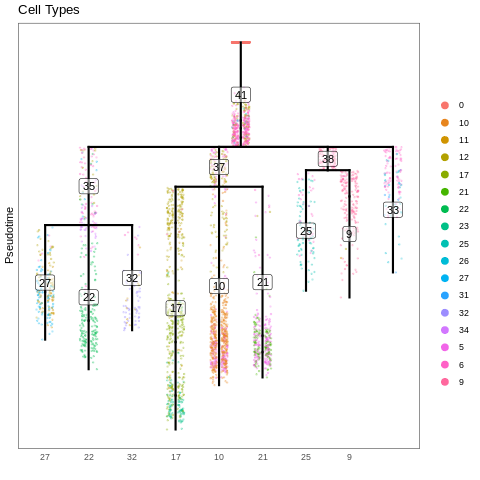

In [25]:
%%R
#lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("26","31","25","27","32","22","17","10","21","9")  , divergence.method = "preference", cells.per.pseudotime.bin = 25, bins.per.pseudotime.window = 10, save.all.breakpoint.info = T, p.thresh=0.01,save.breakpoint.plots ="breakpoint.pdf") 
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types") #GO WITH THIS FOR NOW!!

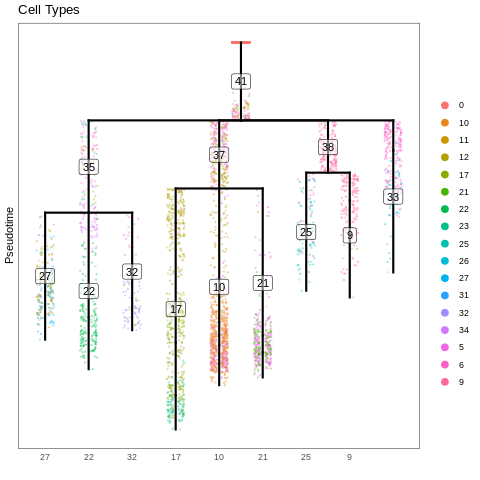

In [23]:
%%R
#lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("26","31","25","27","32","22","17","10","21","9")  , divergence.method = "preference", cells.per.pseudotime.bin = 30, bins.per.pseudotime.window = 10, save.all.breakpoint.info = T, p.thresh=0.01,save.breakpoint.plots ="breakpoint.pdf") #orig, 25 ,8, p =.001,min.cells.per.segment=10
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

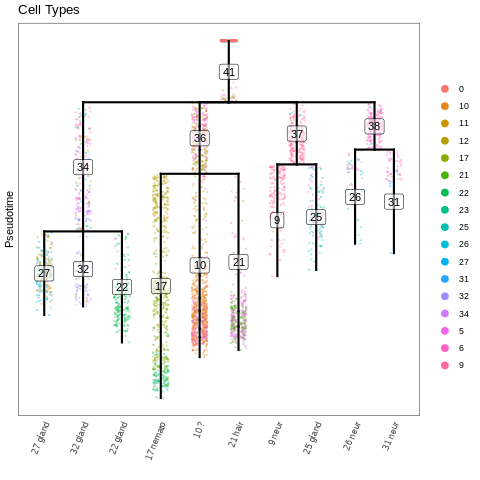

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "17","21","10") 
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

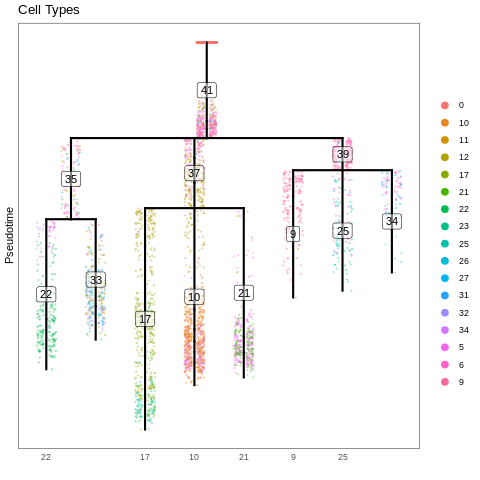

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "17","21","10") 
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

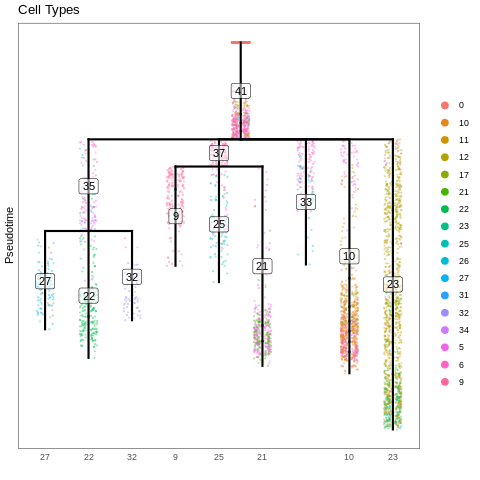

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "23","21","10")  pseudotime = 30
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

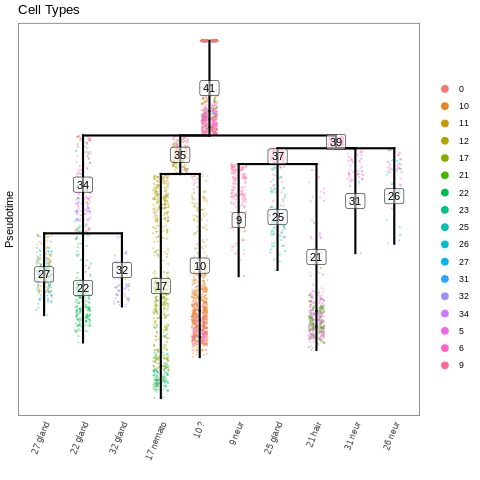

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "17","21","10")  pseudotime = 15
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

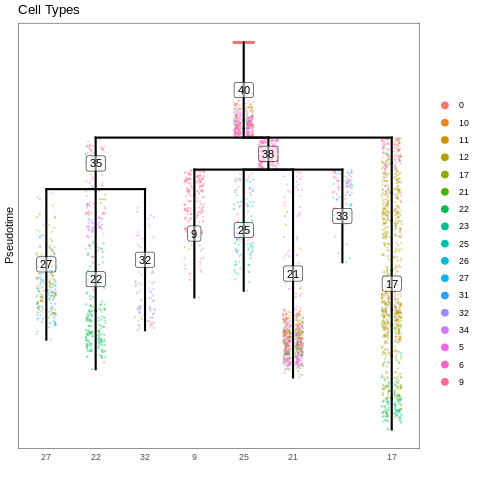

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "17","21")  pseudotime = 50
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

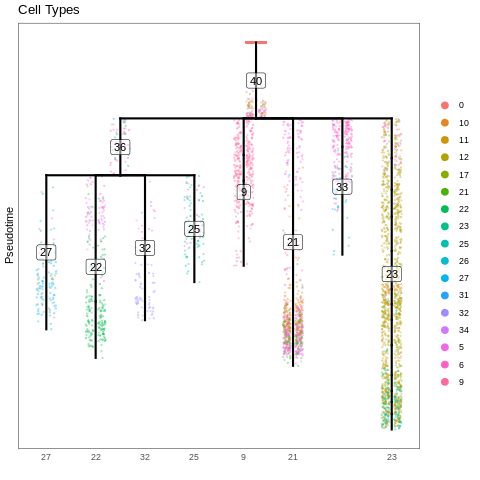

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "23","21")  pseudotime = 50
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

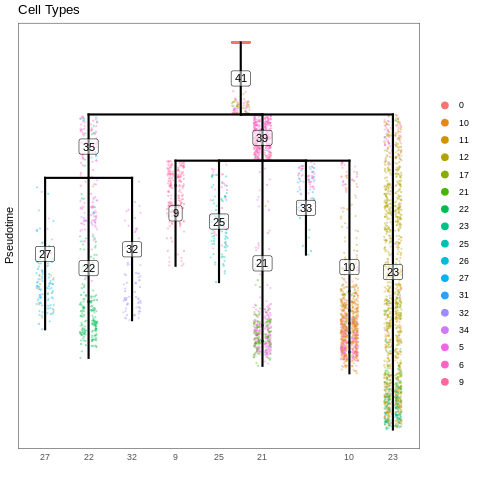

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "23","21","10")  pseudotime = 50
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

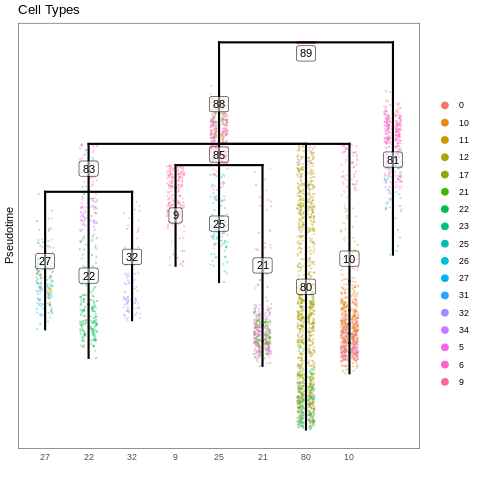

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "80","21","10")  pseudotime = 40, 80 = 17+23
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

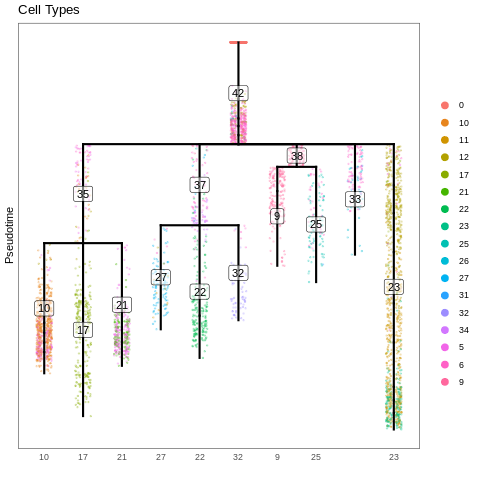

In [ ]:
%%R
# tip.names <- unique(lin@group.ids[,c("stage", "name")])
# tip.names <- tip.names[complete.cases(tip.names),]
# lin.tree <- nameSegments(lin.tree, segments=tip.names$stage, segment.names=tip.names$names)
# #c("26","31","9","27","25","32","22", "17","23","21","10")  pseudotime = 30, 
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

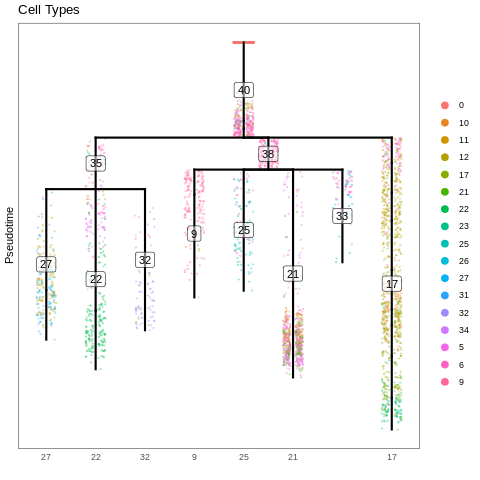

In [ ]:
%%R

# #c("26","31","9","27","25","32","22", "17","21")  pseudotime = 50, 
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

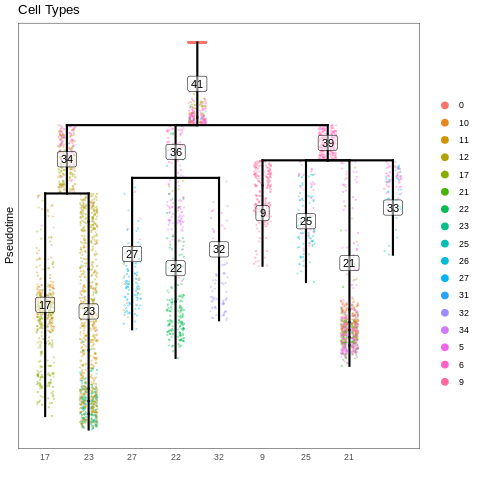

In [ ]:
%%R

# #c("26","31","9","27","25","32","22", "17","21","23")  pseudotime = 50, 
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

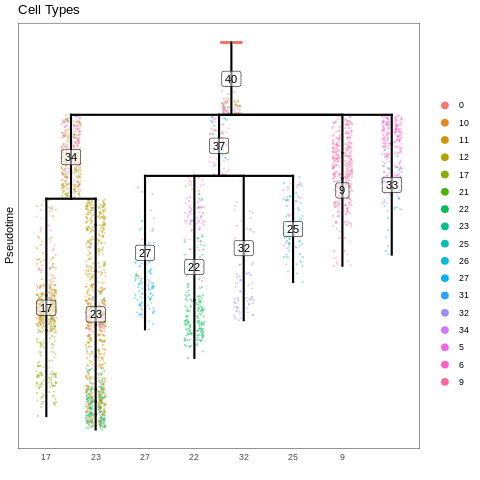

In [ ]:
%%R

# #c("26","31","9","27","25","32","22", "17","23")  pseudotime = 50
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

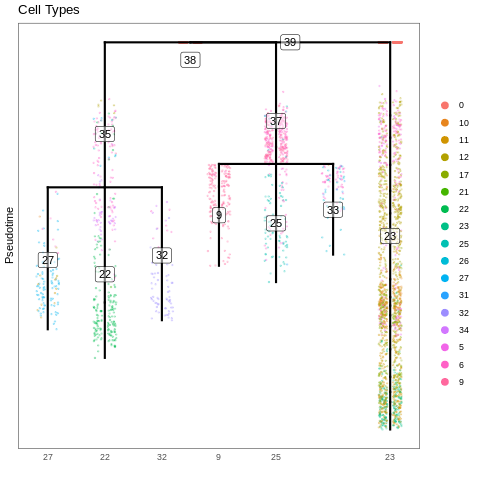

In [ ]:
%%R

# #c("26","31","9","27","25","32","22", "23")  pseudotime = 50
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

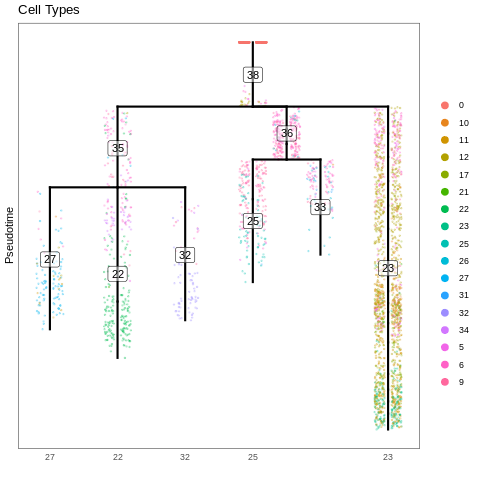

In [ ]:
%%R

# #c("26","31","25","27","32","22", "23")  pseudotime = 50
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

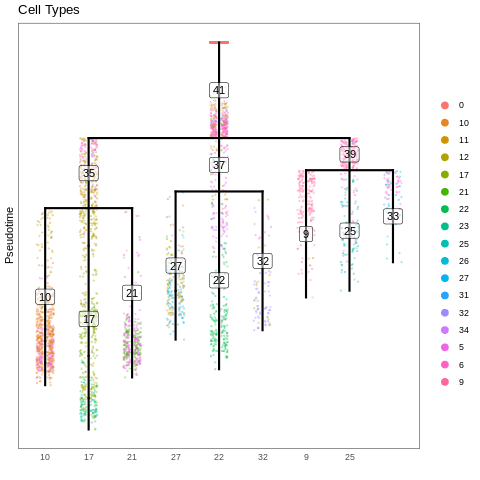

In [ ]:
%%R

# #c("26","31","9","27","25","32","22", "17","21","10")  pseudotime = 50
plotTree(lin.tree,"stage",label.segments=T, title="Cell Types")

In [26]:
%%R
lin.tree <- nameSegments(lin.tree,
   segments=c("26","31","9","27","25","32","22", "17","21","10","35","37","38","41"),
   segment.names=c("26 neur", "31 neur", "9 neur", "27 gland", "25 gland", "32 gland", "22 gland", "17 nemato", "21 hair", "10 ?", "35 glandRoot", "37 nematoRoot", "38 neurRoot", " 41 root")
)

In [ ]:
# %%R
# lin.tree <- treeForceDirectedLayout(lin.tree, num.nn=120, method = "fr", cut.unconnected.segments = 2, min.final.neighbors=4, verbose=T)
# plotTreeForce(lin.tree, "stage")

In [27]:
%%R
tips.to.run <- c("9", "17","21","10","35","37","38")

In [28]:
%%R
# Calculate the markers of each other population.
gene.markers <- list()
for (tipn in 1:length(tips.to.run)) {
  tip <- tips.to.run[tipn]
  print(paste0(Sys.time(), ": ", tip))
  markers <- aucprTestAlongTree(lin.tree, pseudotime="pseudotime", tips=tip, log.effect.size=0.4, auc.factor = 1.25, max.auc.threshold = 0.85, frac.must.express = 0.1, frac.min.diff = 0, root="41", only.return.global=F, must.beat.sibs=0.6, report.debug=T)
  gene.markers[[tip]] <- markers
}

[1] "2021-04-26 16:01:59: 9"
[1] "2021-04-26 16:06:58: 17"
[1] "2021-04-26 16:14:04: 21"
[1] "2021-04-26 16:20:43: 10"
[1] "2021-04-26 16:27:09: 35"
[1] "2021-04-26 16:31:23: 37"
[1] "2021-04-26 16:36:02: 38"


In [29]:
%%R
gene.markers.de <- lapply(gene.markers, function(x) x[[1]])
gene.markers.stats <- lapply(gene.markers[1:23], function(x) x[[2]])
names(gene.markers.de) <- names(gene.markers)
names(gene.markers.stats) <- names(gene.markers)[1:23]


In [30]:
%%R
toPlot <- c("21","10","35","17","38","37")
gene <- list()
segment <- list()
p <- 1
for (c in toPlot){
  fname <- paste("20210426_seg", c,"DE_17_21_10_tips.pdf", sep = "")
  pdf(file=fname, width=7.5, height=10)
  for (i in rownames(gene.markers.de[[c]])){
    plot(plotTree(lin.tree,i, label.segments=T, title=i))

    gene[[p]] <- as.vector(i)
    segment[[p]] <- as.vector(c)

    p <- p+1

  }
  dev.off()
}




In [31]:
%%R
deGenesSeg <- data.frame(Genes = unlist(gene), Segment = unlist(segment))
write.csv(deGenesSeg,"deGenesSeg.csv", row.names = FALSE)


In [32]:
%%R
#Save results, upload to CaltechData
saveRDS(lin, file= "allNeurLinwithDE.rds")

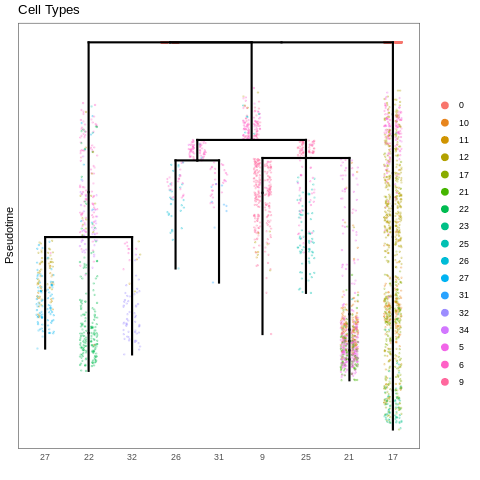

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "17","21")
plotTree(lin.tree, "stage", title="Cell Types")

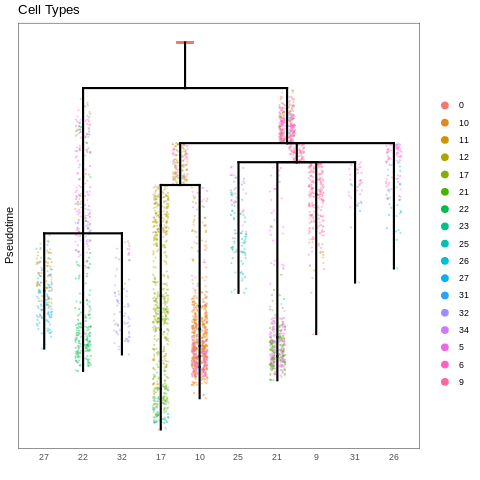

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "17","10","21")
plotTree(lin.tree, "stage", title="Cell Types")

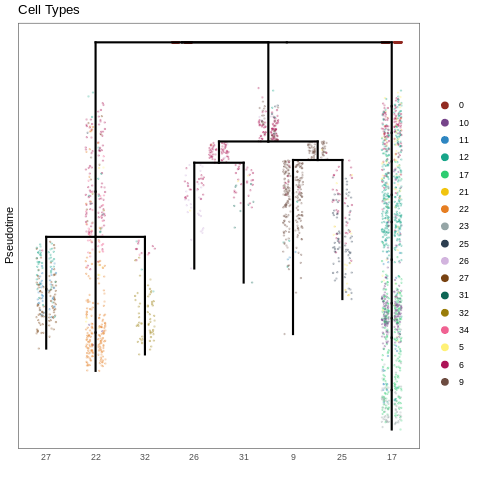

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "17")
plotTree(lin.tree, "stage", title="Cell Types",discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    '#784212','#0E6655','#9A7D0A','#F06292','#FFF176',
                                                                    '#AD1457','#6D4C41'))

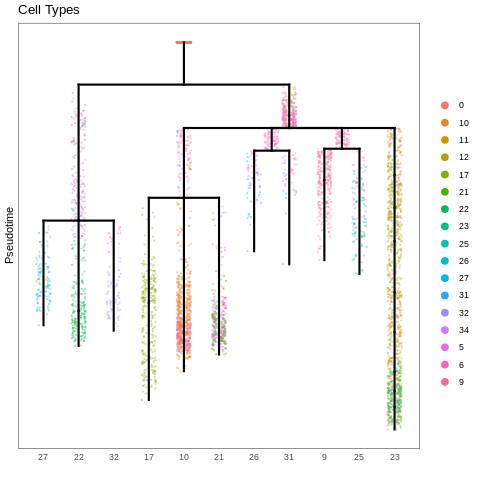

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "17","23","10","21")
plotTree(lin.tree, "stage", title="Cell Types")

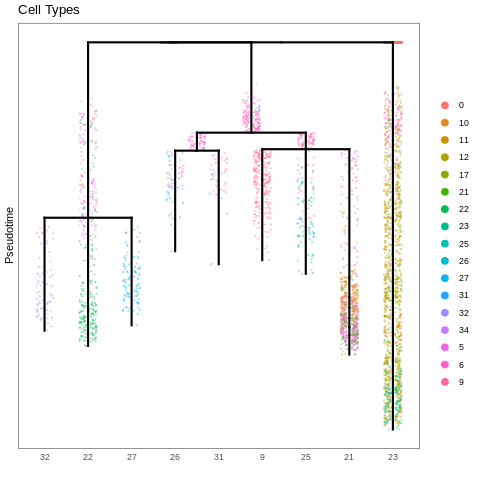

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","21") 
plotTree(lin.tree, "stage", title="Cell Types") #discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    # '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    # '#784212','#0E6655','#9A7D0A','#F06292','#FFF176',
                                                                    # '#AD1457','#6D4C41')

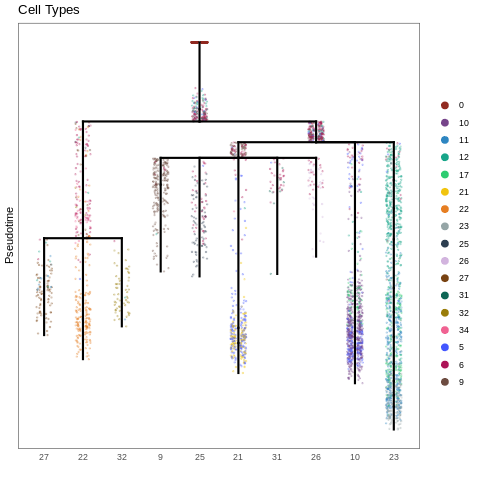

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","10","21")
plotTree(lin.tree, "stage", title="Cell Types", discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    '#784212','#0E6655','#9A7D0A','#F06292','#4357FF',
                                                                    '#AD1457','#6D4C41'))

In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "26","31", new.tip = "26")
# lin.tree <- combineTipVisitation(lin.tree, "9","26", new.tip = "9")

lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("26","31","9","27","25","32","22", "17","21","10")  , divergence.method = "preference", cells.per.pseudotime.bin = 25, bins.per.pseudotime.window = 8, save.all.breakpoint.info = T, p.thresh=0.001)

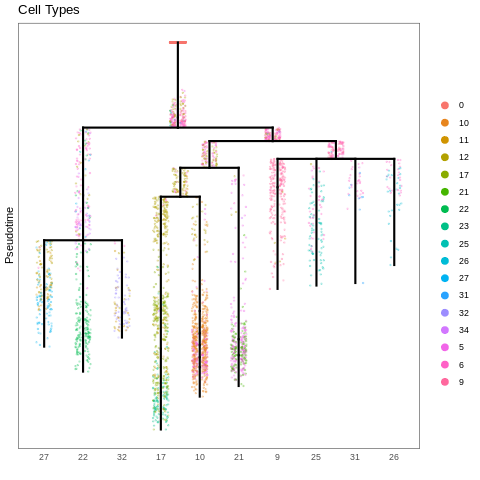

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "17","21","10") 
plotTree(lin.tree, "stage", title="Cell Types")

In [ ]:
%%R
#Save results, upload to CaltechData
saveRDS(lin, file= "allNeurLin17.rds")

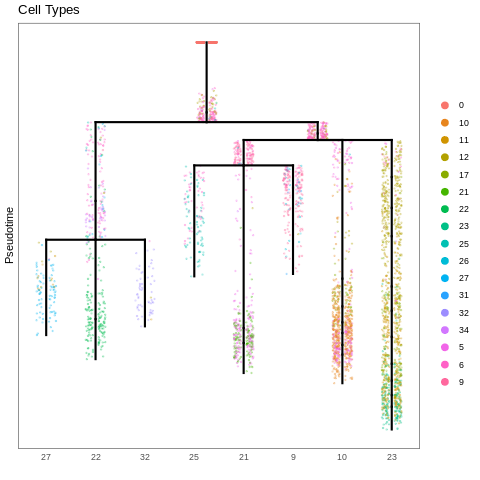

In [ ]:
%%R
#c("9","27","25","32","22", "23","21","10") 
plotTree(lin.tree, "stage", title="Cell Types")

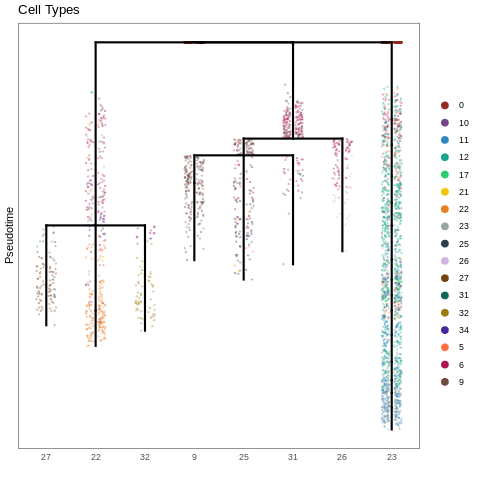

In [ ]:
%%R
#No 10,21 tips
plotTree(lin.tree, "stage", title="Cell Types", discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    '#784212','#0E6655','#9A7D0A','#4527A0','#FF7043',
                                                                    '#AD1457','#6D4C41'))

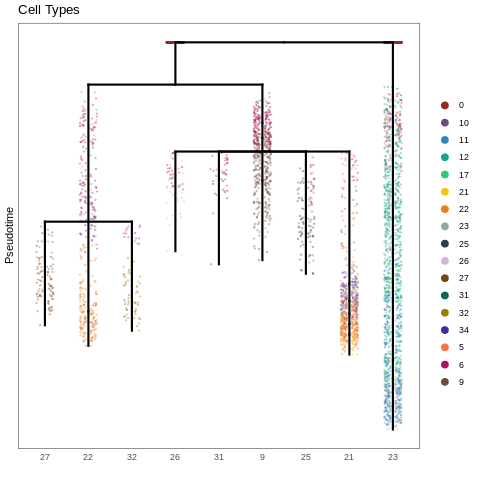

In [ ]:
%%R
#No 10 tip
plotTree(lin.tree, "stage", title="Cell Types", discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    '#784212','#0E6655','#9A7D0A','#4527A0','#FF7043',
                                                                    '#AD1457','#6D4C41'))

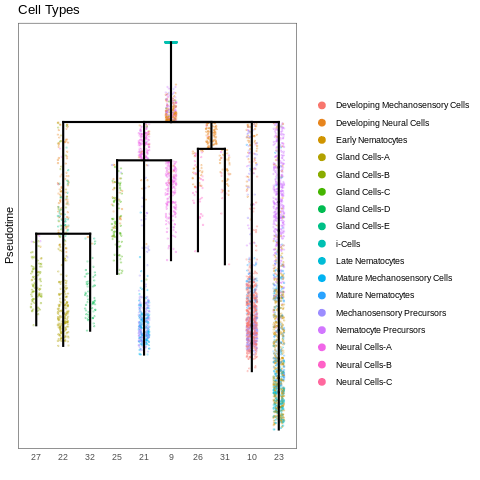

In [ ]:
%%R
plotTree(lin.tree, "name", title="Cell Types")

##### **Read in Saved Lineage Data for Plotting**

In [ ]:
%%R
#Read in saved file
lin <- readRDS(file="allNeurLin17.rds")
lin

URD object: 20674 genes x 4914 cells.


##### **Test Neurons without 17**

In [ ]:
%%R

# Create an URD object, which will filter the data, then normalize and log-transform it.
lin <- createURD(count.data = subDF, meta = subMeta, min.cells=3, min.counts=3, max.genes.in.ram = 100)
lin

R[write to console]: 2021-04-15 15:50:15: Filtering cells by number of genes.

R[write to console]: 2021-04-15 15:50:32: Filtering genes by number of cells.

R[write to console]: 2021-04-15 15:50:48: Filtering genes by number of counts across entire data.

R[write to console]: 2021-04-15 15:50:59: Filtering genes by maximum observed expression.

R[write to console]: 2021-04-15 15:51:11: Creating URD object.

R[write to console]: 2021-04-15 15:51:13: Determining normalization factors.

R[write to console]: 2021-04-15 15:51:18: Normalizing and log-transforming the data.

R[write to console]: 2021-04-15 15:52:00: Finishing setup of the URD object.

R[write to console]: 2021-04-15 15:52:03: All done.



URD object: 17262 genes x 4673 cells.


In [ ]:
%%R
# Copy stage from @meta to @group.ids 
lin@group.ids$stage <- as.character(lin@meta[rownames(lin@group.ids),"cluster"])

# Get variable genes for each group of stages
# diffCV.cutoff can be varied to include more or fewer genes.
stages <- sort(unique(lin@group.ids$stage))
var.by.stage <- lapply(seq(length(stages)), function(n) {
  findVariableGenes(lin, cells.fit=cellsInCluster(lin, "stage", stages[n]), set.object.var.genes=F, diffCV.cutoff=0.3, mean.min=.005, mean.max=100, main.use=paste0("Stages ", stages[n]), do.plot=F)
})

In [ ]:
%%R
# Combine the results from each group of stages into a single list of variable genes and load into the URD object
var.genes <- sort(unique(unlist(var.by.stage)))
lin@var.genes <- var.genes

[1] "2021-04-15 15:52:31: Centering and scaling data."
[1] "2021-04-15 15:52:37: Removing genes with no variation."
[1] "2021-04-15 15:52:39: Calculating PCA."
[1] "2021-04-15 15:54:26: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 4.22045450096323"
[1] "32 PCs have eigenvalues larger than 2 times null upper bound."
[1] "Storing 64 PCs."


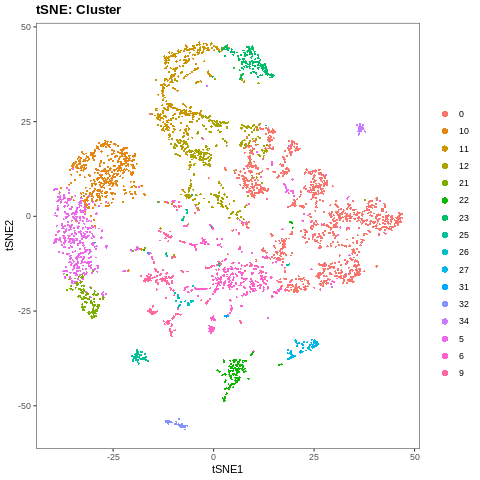

In [ ]:
%%R
# Calculate PCA and consider those PCs that with standard deviation 2x expected by noise as significant
lin <- calcPCA(lin, mp.factor = 2)
#pcSDPlot(lin)

# Calculate tSNE
set.seed(42)
lin <- calcTsne(object = lin)
plotDim(lin, "stage", plot.title = "tSNE: Cluster")

[1] "destiny determined an optimal global sigma of 27.444"


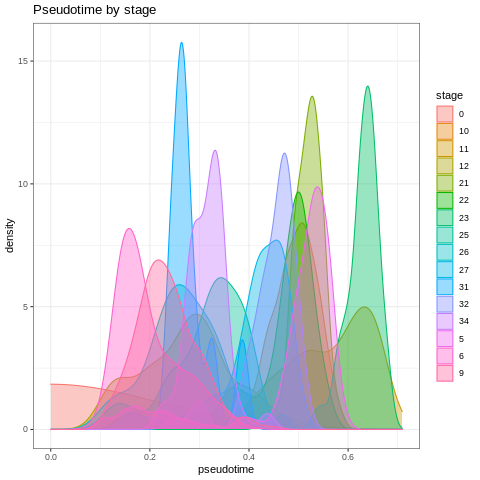

In [ ]:
%%R
# In this case, knn=100 (larger than sqrt(n.cells)) works well because there are not many cell types.
# Sigma 16 is slightly smaller than the sigma auto-determined by using NULL parameter.
lin <- calcDM(lin, knn = 60)
# Here we use all cells from the first stage as the root
root.cells <- cellsInCluster(lin, "stage", "0")

# Then we run 'flood' simulations
lin.floods <- floodPseudotime(lin, root.cells = root.cells, n=50, minimum.cells.flooded = 2, verbose=F)

# The we process the simulations into a pseudotime
lin <- floodPseudotimeProcess(lin, lin.floods, floods.name="pseudotime")

pseudotimePlotStabilityOverall(lin)

plotDists(lin, "pseudotime", "stage", plot.title="Pseudotime by stage")

[1] "2021-04-15 16:07:28: Centering and scaling data."
[1] "2021-04-15 16:07:29: Removing genes with no variation."
[1] "2021-04-15 16:07:30: Calculating PCA."
[1] "2021-04-15 16:07:39: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 8.06703098891053"
[1] "26 PCs have eigenvalues larger than 1.5 times null upper bound."
[1] "Storing 52 PCs."


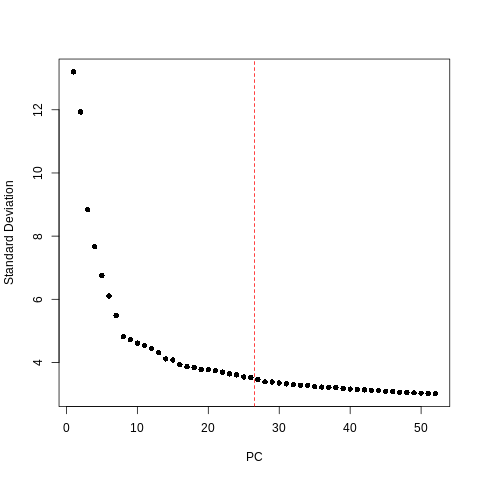

In [ ]:
%%R
# Create a subsetted object of just those cells from the final stage
#Test c(26,31,9,27,25,32,34,22,21, 23) , c(26,31,9,27,25,32,34,22, 23), c(26,31,9,27,25,32,34,22,10, 23)
lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c("26","31","9","27","25","32","22", "23","21","10")))

# Use the variable genes that were calculated only on the final group of stages (which
# contain the last stage).
#lin.tips@var.genes <- var.by.stage[[4]]

# Calculate PCA and tSNE
lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
pcSDPlot(lin.tips)

[1] "Mean pseudotime back (~40 cells) 0.00588125863330023"
[1] "Chance of accepted move to equal pseudotime is 0.82065308663136"
[1] "Mean pseudotime forward (~20 cells) -0.00296119121593662"


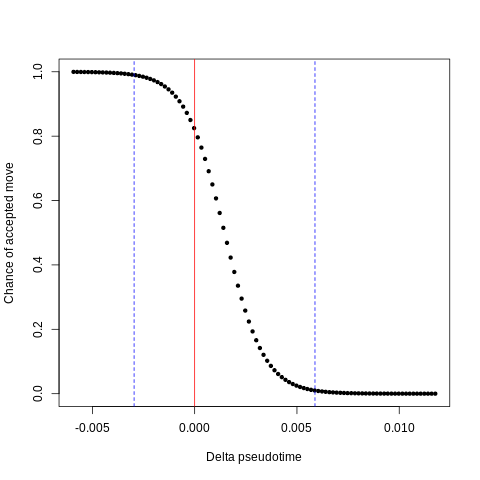

In [ ]:
%%R
# Calculate graph clustering of these cells
#lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$stage

# Determine the parameters of the logistic used to bias the transition probabilities. The procedure
# is relatively robust to this parameter, but the cell numbers may need to be modified for larger
# or smaller data sets.
lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=20, max.cells.back=40, do.plot = T)

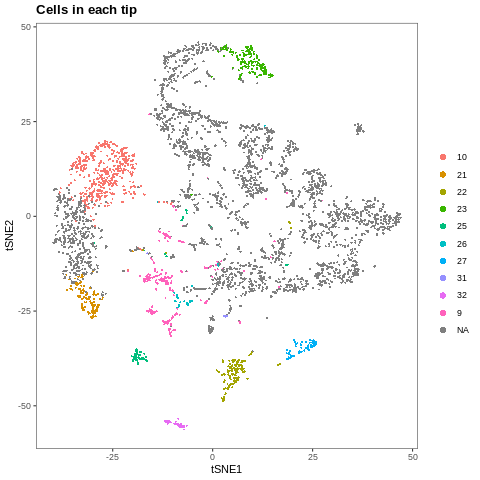

In [ ]:
%%R
# Bias the transition matrix acording to pseudotime
lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# Simulate the biased random walks from each tip
lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm, n.per.tip = 25000, root.visits = 1, max.steps = 5000, verbose = F)

# Process the biased random walks into visitation frequencies
lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

#Plot tips
plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


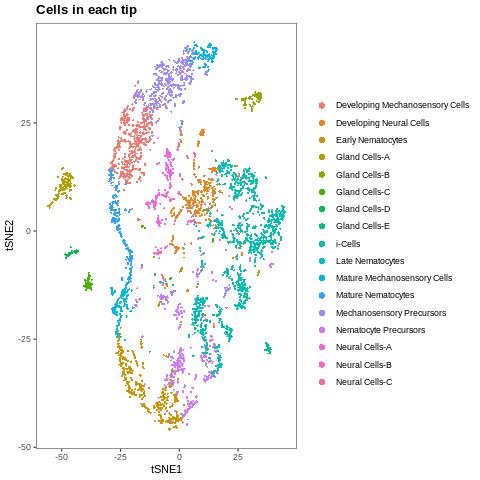

In [ ]:
%%R
plotDim(lin, "name", plot.title="Cells in each tip")

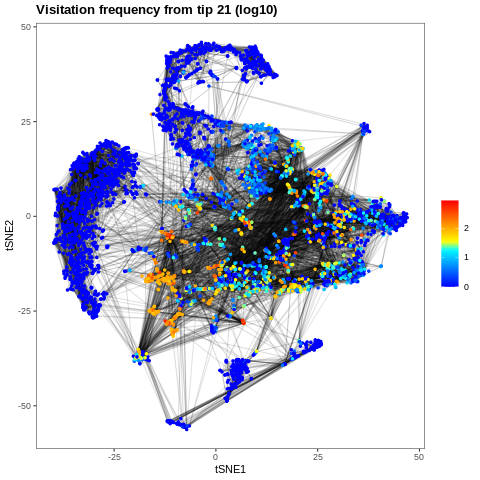

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.9", plot.title="Visitation frequency from tip 21 (log10)", transitions.plot=10000)



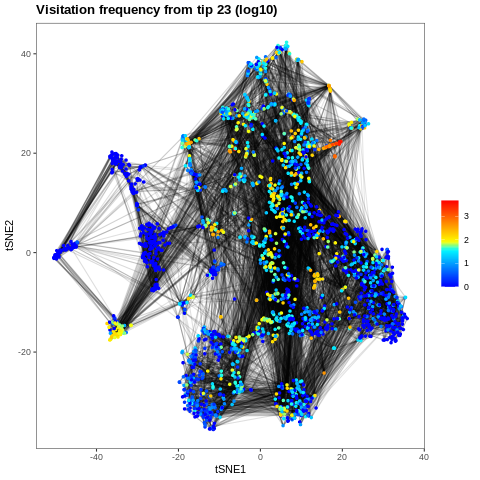

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.31", plot.title="Visitation frequency from tip 23 (log10)", transitions.plot=10000)


In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "16", "5", new.tip = "16")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
#c("26","31","9","27","25","32","22", "23")
#c("26","31","9","27","25","32","22", "23","21")
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("26","31","9","27","25","32","22", "23","10","21"), divergence.method = "preference", cells.per.pseudotime.bin = 25, bins.per.pseudotime.window = 8, save.all.breakpoint.info = T, p.thresh=0.001)

[1] "Calculating divergence between 26 and 31 (Pseudotime 0 to 0.369)"
[1] "Calculating divergence between 26 and 9 (Pseudotime 0 to 0.369)"
[1] "Calculating divergence between 26 and 27 (Pseudotime 0 to 0.369)"


R[write to console]: Difference between 26 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 25 (Pseudotime 0 to 0.369)"
[1] "Calculating divergence between 26 and 32 (Pseudotime 0 to 0.369)"


R[write to console]: Difference between 26 and 32 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 22 (Pseudotime 0 to 0.369)"


R[write to console]: Difference between 26 and 22 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 23 (Pseudotime 0 to 0.369)"


R[write to console]: Difference between 26 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 10 (Pseudotime 0 to 0.369)"
[1] "Calculating divergence between 26 and 21 (Pseudotime 0 to 0.369)"
[1] "Calculating divergence between 31 and 9 (Pseudotime 0 to 0.387)"
[1] "Calculating divergence between 31 and 27 (Pseudotime 0 to 0.387)"


R[write to console]: Difference between 31 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 25 (Pseudotime 0 to 0.387)"
[1] "Calculating divergence between 31 and 32 (Pseudotime 0 to 0.387)"
[1] "Calculating divergence between 31 and 22 (Pseudotime 0 to 0.387)"
[1] "Calculating divergence between 31 and 23 (Pseudotime 0 to 0.387)"
[1] "Calculating divergence between 31 and 10 (Pseudotime 0 to 0.387)"
[1] "Calculating divergence between 31 and 21 (Pseudotime 0 to 0.387)"
[1] "Calculating divergence between 9 and 27 (Pseudotime 0 to 0.431)"


R[write to console]: Difference between 9 and 27 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 9 and 25 (Pseudotime 0 to 0.418)"
[1] "Calculating divergence between 9 and 32 (Pseudotime 0 to 0.431)"
[1] "Calculating divergence between 9 and 22 (Pseudotime 0 to 0.431)"
[1] "Calculating divergence between 9 and 23 (Pseudotime 0 to 0.431)"


R[write to console]: Difference between 9 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 9 and 10 (Pseudotime 0 to 0.431)"
[1] "Calculating divergence between 9 and 21 (Pseudotime 0 to 0.431)"
[1] "Calculating divergence between 27 and 25 (Pseudotime 0 to 0.418)"


R[write to console]: Difference between 27 and 25 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.497)"
[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.497)"
[1] "Calculating divergence between 27 and 23 (Pseudotime 0 to 0.497)"


R[write to console]: Difference between 27 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 10 (Pseudotime 0 to 0.497)"


R[write to console]: Difference between 27 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 21 (Pseudotime 0 to 0.497)"


R[write to console]: Difference between 27 and 21 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.418)"
[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.418)"
[1] "Calculating divergence between 25 and 23 (Pseudotime 0 to 0.418)"


R[write to console]: Difference between 25 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 10 (Pseudotime 0 to 0.418)"


R[write to console]: Difference between 25 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 21 (Pseudotime 0 to 0.418)"
[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.511)"
[1] "Calculating divergence between 32 and 23 (Pseudotime 0 to 0.511)"


R[write to console]: Difference between 32 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 10 (Pseudotime 0 to 0.511)"


R[write to console]: Difference between 32 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 21 (Pseudotime 0 to 0.511)"


R[write to console]: Difference between 32 and 21 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 22 and 23 (Pseudotime 0 to 0.565)"
[1] "Calculating divergence between 22 and 10 (Pseudotime 0 to 0.565)"


R[write to console]: Difference between 22 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 22 and 21 (Pseudotime 0 to 0.565)"
[1] "Calculating divergence between 23 and 10 (Pseudotime 0 to 0.583)"
[1] "Calculating divergence between 23 and 21 (Pseudotime 0 to 0.587)"
[1] "Calculating divergence between 10 and 21 (Pseudotime 0 to 0.583)"
[1] "Joining segments 27 and 22 at pseudotime 0.325 to create segment 33"
[1] "Calculating divergence between 26 and 33 (Pseudotime 0 to 0.325)"


R[write to console]: Difference between 26 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 33 (Pseudotime 0 to 0.325)"
[1] "Calculating divergence between 9 and 33 (Pseudotime 0 to 0.325)"
[1] "Calculating divergence between 25 and 33 (Pseudotime 0 to 0.325)"
[1] "Calculating divergence between 32 and 33 (Pseudotime 0 to 0.325)"


R[write to console]: Difference between 32 and 33 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 23 and 33 (Pseudotime 0 to 0.325)"
[1] "Calculating divergence between 10 and 33 (Pseudotime 0 to 0.325)"


R[write to console]: Difference between 10 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 33 (Pseudotime 0 to 0.325)"
[1] "Joining segments 32 and 33 at pseudotime 0.324 to create segment 34"
[1] "Calculating divergence between 26 and 34 (Pseudotime 0 to 0.324)"


R[write to console]: Difference between 26 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 34 (Pseudotime 0 to 0.324)"
[1] "Calculating divergence between 9 and 34 (Pseudotime 0 to 0.324)"
[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.324)"
[1] "Calculating divergence between 23 and 34 (Pseudotime 0 to 0.324)"
[1] "Calculating divergence between 10 and 34 (Pseudotime 0 to 0.324)"


R[write to console]: Difference between 10 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 34 (Pseudotime 0 to 0.324)"
[1] "Joining segments 10 and 21 at pseudotime 0.215 to create segment 35"
[1] "Calculating divergence between 26 and 35 (Pseudotime 0 to 0.215)"
[1] "Calculating divergence between 31 and 35 (Pseudotime 0 to 0.215)"
[1] "Calculating divergence between 9 and 35 (Pseudotime 0 to 0.215)"
[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.215)"
[1] "Calculating divergence between 23 and 35 (Pseudotime 0 to 0.215)"
[1] "Calculating divergence between 34 and 35 (Pseudotime 0 to 0.215)"


R[write to console]: Difference between 34 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 26 and 31 at pseudotime 0.202 to create segment 36"
[1] "Calculating divergence between 9 and 36 (Pseudotime 0 to 0.202)"
[1] "Calculating divergence between 25 and 36 (Pseudotime 0 to 0.202)"
[1] "Calculating divergence between 23 and 36 (Pseudotime 0 to 0.202)"


R[write to console]: Difference between 23 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 36 (Pseudotime 0 to 0.202)"


R[write to console]: Difference between 34 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 35 and 36 (Pseudotime 0 to 0.202)"
[1] "Joining segments 9 and 25 at pseudotime 0.199 to create segment 37"
[1] "Calculating divergence between 23 and 37 (Pseudotime 0 to 0.199)"


R[write to console]: Difference between 23 and 37 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 37 (Pseudotime 0 to 0.199)"
[1] "Calculating divergence between 35 and 37 (Pseudotime 0 to 0.199)"
[1] "Calculating divergence between 36 and 37 (Pseudotime 0 to 0.199)"
[1] "Joining segments 36 and 37 at pseudotime 0.152 to create segment 38"
[1] "Calculating divergence between 23 and 38 (Pseudotime 0 to 0.152)"


R[write to console]: Difference between 23 and 38 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 38 (Pseudotime 0 to 0.152)"
[1] "Calculating divergence between 35 and 38 (Pseudotime 0 to 0.152)"


R[write to console]: Difference between 35 and 38 always FALSE -- setting breakpoint to end.



[1] "Joining segments 35 and 38 at pseudotime 0.152 to create segment 39"
[1] "Calculating divergence between 23 and 39 (Pseudotime 0 to 0.152)"


R[write to console]: Difference between 23 and 39 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 34 and 39 (Pseudotime 0 to 0.152)"
[1] "Joining segments 23 and 39 at pseudotime 0.152 to create segment 40"
[1] "Calculating divergence between 34 and 40 (Pseudotime 0 to 0.152)"


R[write to console]: Difference between 34 and 40 always FALSE -- setting breakpoint to end.



[1] "Joining segments 34 and 40 at pseudotime 0.152 to create segment 41"
[1] "Assigning cells to segments."
[1] "Collapsing short segments."
[1] "Removing singleton segments."
[1] "Reassigning cells to segments."
[1] "Assigning cells to nodes."
[1] "Laying out tree."
[1] "Adding cells to tree."


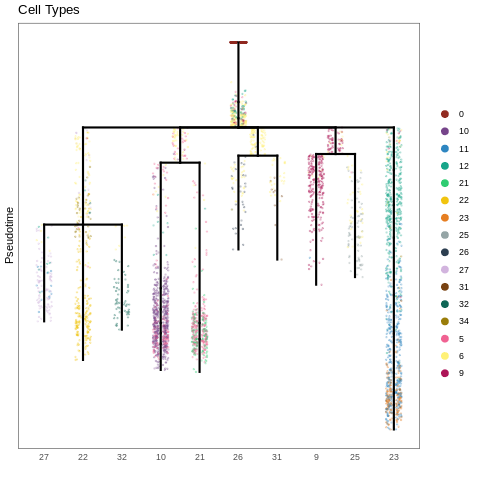

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","10","21")
plotTree(lin.tree, "stage", title="Cell Types", discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    '#784212','#0E6655','#9A7D0A','#F06292','#FFF176',
                                                                    '#AD1457','#6D4C41'))

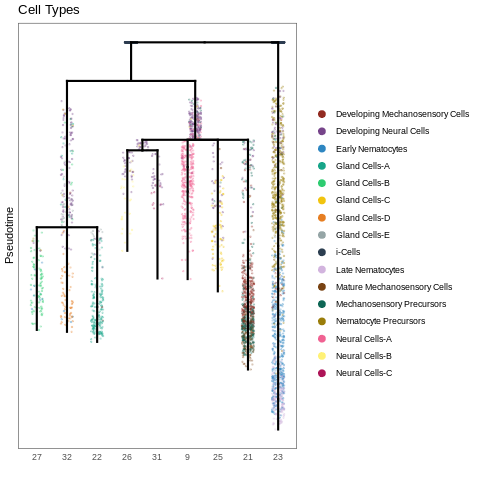

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","10","21")
plotTree(lin.tree, "name", title="Cell Types",discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    '#784212','#0E6655','#9A7D0A','#F06292','#FFF176',
                                                                    '#AD1457','#6D4C41'))

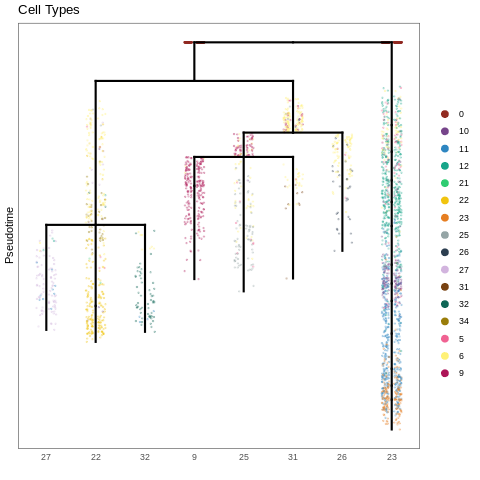

In [ ]:
%%R
#No 10/21
#c("26","31","9","27","25","32","22", "23")
plotTree(lin.tree, "stage", title="Cell Types", discrete.colors = c('#922B21','#76448A','#2E86C1','#17A589','#2ECC71',
                                                                    '#F1C40F','#E67E22','#95A5A6','#2C3E50','#D2B4DE',
                                                                    '#784212','#0E6655','#9A7D0A','#F06292','#FFF176',
                                                                    '#AD1457','#6D4C41'))

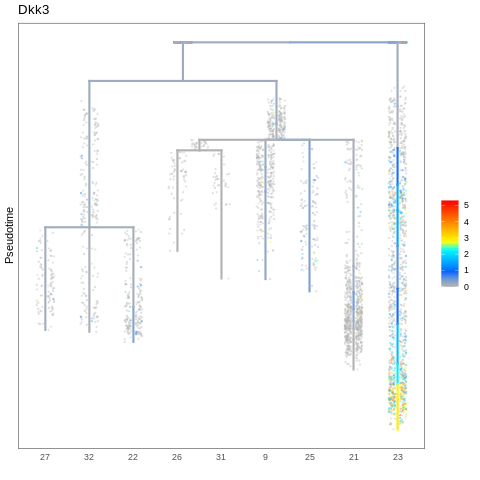

In [ ]:
%%R

plotTree(lin.tree,"XLOC_030068", title="Dkk3")

##### **Test control tree with outgroup i-cell derived cells**

In [ ]:
%%R
neurDF <- t(as.matrix(readMM("controlLineage.mtx")))

genes <- read.table("controlGenes.csv", header = TRUE, sep = ",")
neurMeta <- read.table("controlLinMeta.csv", header = TRUE, sep = ",")

rownames(neurDF) <- genes$genes
colnames(neurDF) <- neurMeta$index

rownames(neurMeta) <- neurMeta$index


# Create an URD object, which will filter the data, then normalize and log-transform it.
lin <- createURD(count.data = neurDF, meta = neurMeta, min.cells=1, min.counts=1, max.genes.in.ram = 100)
lin

R[write to console]: 2021-04-23 21:38:10: Filtering cells by number of genes.

R[write to console]: 2021-04-23 21:38:29: Filtering genes by number of cells.

R[write to console]: 2021-04-23 21:38:50: Filtering genes by number of counts across entire data.

R[write to console]: 2021-04-23 21:39:07: Filtering genes by maximum observed expression.

R[write to console]: 2021-04-23 21:39:26: Creating URD object.

R[write to console]: 2021-04-23 21:39:28: Determining normalization factors.

R[write to console]: 2021-04-23 21:39:33: Normalizing and log-transforming the data.

R[write to console]: 2021-04-23 21:40:25: Finishing setup of the URD object.

R[write to console]: 2021-04-23 21:40:28: All done.



URD object: 21330 genes x 5147 cells.


In [ ]:
%%R
# Copy stage from @meta to @group.ids 
lin@group.ids$stage <- as.character(lin@meta[rownames(lin@group.ids),"cluster"])

# Get variable genes for each group of stages
# diffCV.cutoff can be varied to include more or fewer genes.
stages <- sort(unique(lin@group.ids$stage))
var.by.stage <- lapply(seq(length(stages)), function(n) {
  findVariableGenes(lin, cells.fit=cellsInCluster(lin, "stage", stages[n]), set.object.var.genes=F, diffCV.cutoff=0.3, mean.min=.005, mean.max=100, main.use=paste0("Stages ", stages[n]), do.plot=F)
})

In [ ]:
%%R
# Combine the results from each group of stages into a single list of variable genes and load into the URD object
var.genes <- sort(unique(unlist(var.by.stage)))
lin@var.genes <- var.genes

[1] "2021-04-23 21:41:38: Centering and scaling data."
[1] "2021-04-23 21:41:49: Removing genes with no variation."
[1] "2021-04-23 21:41:51: Calculating PCA."
[1] "2021-04-23 21:44:52: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 4.65879528419891"
[1] "31 PCs have eigenvalues larger than 2 times null upper bound."
[1] "Storing 62 PCs."


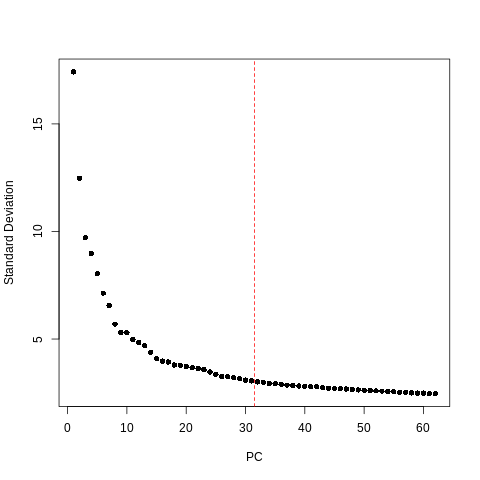

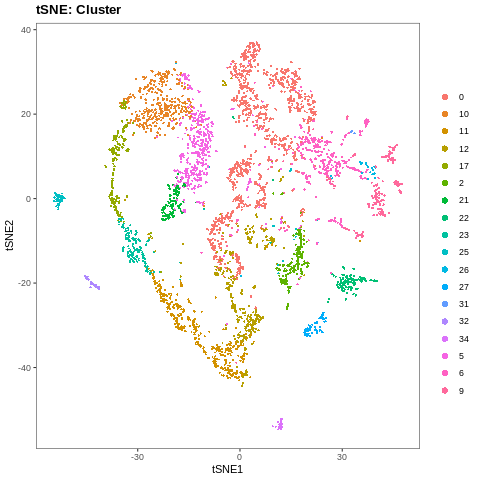

In [ ]:
%%R
# Calculate PCA and consider those PCs that with standard deviation 2x expected by noise as significant
lin <- calcPCA(lin, mp.factor = 2)
pcSDPlot(lin)

# Calculate tSNE
set.seed(42)
lin <- calcTsne(object = lin)
plotDim(lin, "stage", plot.title = "tSNE: Cluster")

[1] "destiny determined an optimal global sigma of 27.115"


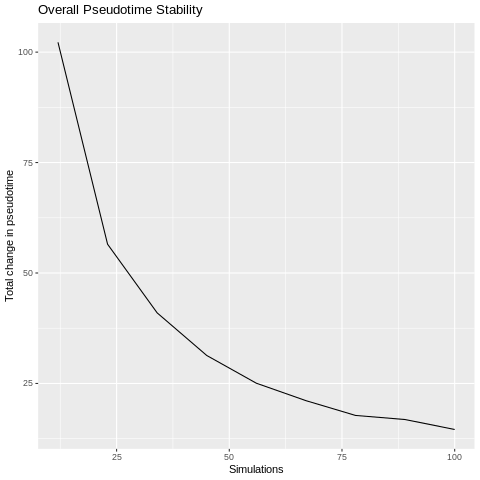

In [ ]:
%%R
# In this case, knn=100 (larger than sqrt(n.cells)) works well because there are not many cell types.
# Sigma 16 is slightly smaller than the sigma auto-determined by using NULL parameter.
lin <- calcDM(lin, knn = 60)
# Here we use all cells from the first stage as the root
root.cells <- cellsInCluster(lin, "stage", "0")

# Then we run 'flood' simulations
lin.floods <- floodPseudotime(lin, root.cells = root.cells, n=100, minimum.cells.flooded = 2, verbose=F)

# The we process the simulations into a pseudotime
lin <- floodPseudotimeProcess(lin, lin.floods, floods.name="pseudotime")

pseudotimePlotStabilityOverall(lin)



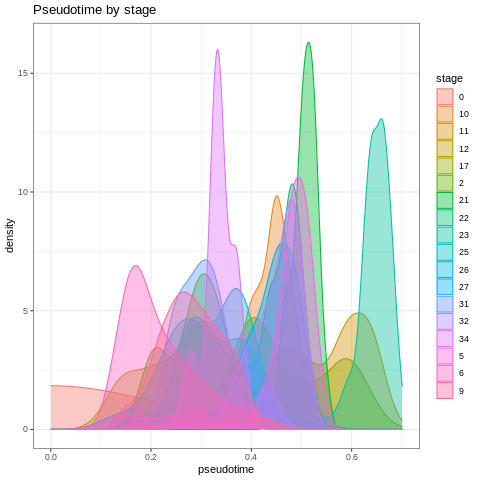

In [ ]:
%%R
#Check pseudotime assignments per cell type
plotDists(lin, "pseudotime", "stage", plot.title="Pseudotime by stage")

[1] "2021-04-23 22:14:02: Centering and scaling data."
[1] "2021-04-23 22:14:05: Removing genes with no variation."
[1] "2021-04-23 22:14:06: Calculating PCA."
[1] "2021-04-23 22:14:29: Estimating significant PCs."
[1] "Marchenko-Pastur eigenvalue null upper bound: 8.04989603099451"
[1] "28 PCs have eigenvalues larger than 1.5 times null upper bound."
[1] "Storing 56 PCs."


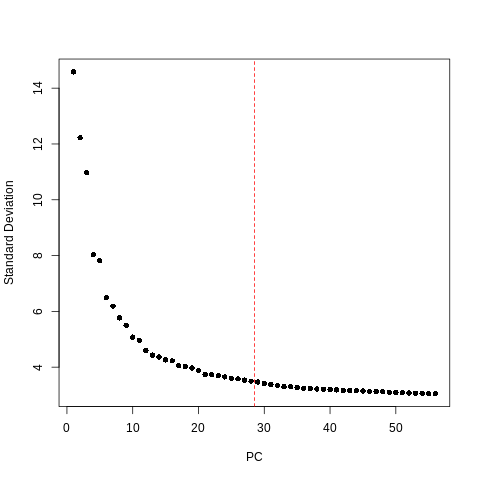

In [ ]:
%%R
# Create a subsetted object of just those cells from the final stage
#Test c(26,31,9,27,25,32,34,22,21, 23) , c(26,31,9,27,25,32,34,22, 23), c(26,31,9,27,25,32,34,22,10, 23)
lin.tips <- urdSubset(lin, cells.keep=cellsInCluster(lin, "stage",  c(26,31,9,27,25,32,34,22, 17,10,21, 23,2)))

# Use the variable genes that were calculated only on the final group of stages (which
# contain the last stage).
#lin.tips@var.genes <- var.by.stage[[4]]

# Calculate PCA and tSNE
lin.tips <- calcPCA(lin.tips, mp.factor = 1.5)
pcSDPlot(lin.tips)

[1] "Mean pseudotime back (~100 cells) 0.0132731806662228"
[1] "Chance of accepted move to equal pseudotime is 0.99009900990099"
[1] "Mean pseudotime forward (~0 cells) 0"


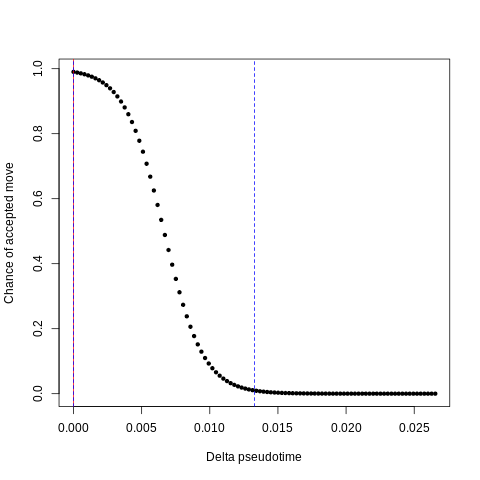

In [ ]:
%%R
# Calculate graph clustering of these cells
#lin.tips <- graphClustering(lin.tips, num.nn = 50, do.jaccard=T, method="Louvain")

# Copy cluster identities from axial.6somite object to a new clustering ("tip.clusters") in the full axial object.
lin@group.ids[rownames(lin.tips@group.ids), "tip.clusters"] <- lin.tips@group.ids$stage

# Determine the parameters of the logistic used to bias the transition probabilities. The procedure
# is relatively robust to this parameter, but the cell numbers may need to be modified for larger
# or smaller data sets.
lin.ptlogistic <- pseudotimeDetermineLogistic(lin, "pseudotime", optimal.cells.forward=0, max.cells.back=100, do.plot = T) #20, 40

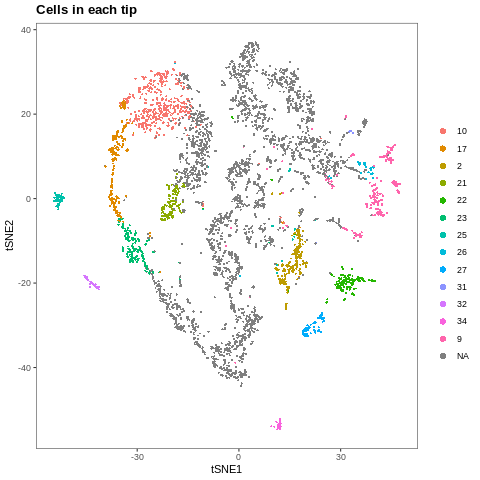

In [ ]:
%%R
# Bias the transition matrix acording to pseudotime
lin.biased.tm <- as.matrix(pseudotimeWeightTransitionMatrix(lin, "pseudotime", logistic.params=lin.ptlogistic))

# Simulate the biased random walks from each tip
lin.walks <- simulateRandomWalksFromTips(lin, tip.group.id="tip.clusters", root.cells=root.cells, transition.matrix = lin.biased.tm,n.per.tip = 20000, root.visits = 1, max.steps = 5000, verbose = F)

# Process the biased random walks into visitation frequencies
lin <- processRandomWalksFromTips(lin, lin.walks, verbose = F)

#Plot tips
plotDim(lin, "tip.clusters", plot.title="Cells in each tip")


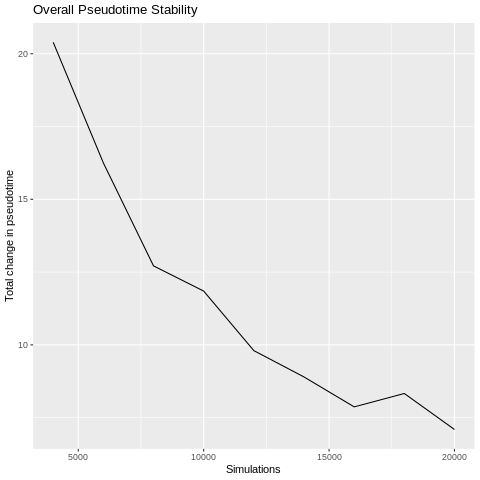

In [ ]:
%%R
pseudotimePlotStabilityOverall(lin)

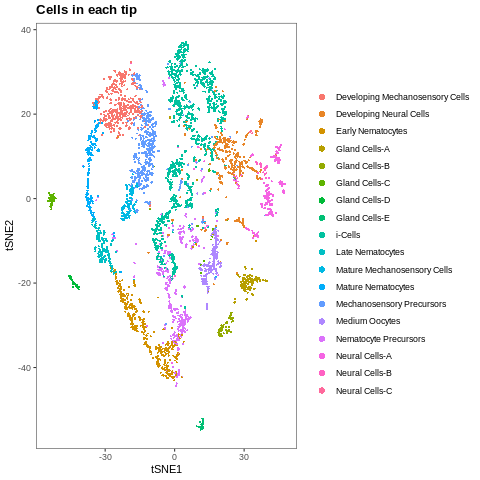

In [ ]:
%%R
plotDim(lin, "name", plot.title="Cells in each tip")

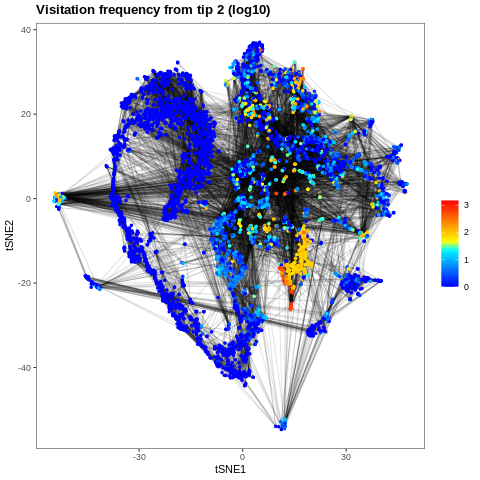

In [ ]:
%%R
#Plot visitation frequencies from tips
plotDim(lin, "visitfreq.log.2", plot.title="Visitation frequency from tip 2 (log10)", transitions.plot=10000)



In [ ]:
%%R
# Load the cells used for each tip into the URD object
lin.tree <- loadTipCells(lin, "tip.clusters")

# # Combine the two small clusters in a single population into one tip
# lin.tree <- combineTipVisitation(lin.tree, "16", "5", new.tip = "16")

# Build the tree,  c(10,21,17,23,27,25,32,34,22) = tips
#c("26","31","9","27","25","32","22", "23")
#c("26","31","9","27","25","32","22", "23","21")

#c("26","31","9","27","25","32","22", "17","21")
#c("26","31","9","27","25","32","22", "17")
lin.tree <- buildTree(lin.tree, pseudotime = "pseudotime", tips.use=c("26","31","9","27","25","32","22", "23","21","10", "2")  , divergence.method = "preference", cells.per.pseudotime.bin = 30, bins.per.pseudotime.window = 8, save.all.breakpoint.info = T, p.thresh=0.005)

[1] "Calculating divergence between 26 and 31 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 9 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 27 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 25 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 32 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 22 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 23 (Pseudotime 0 to 0.414)"


R[write to console]: Difference between 26 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 26 and 21 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 10 (Pseudotime 0 to 0.414)"
[1] "Calculating divergence between 26 and 2 (Pseudotime 0 to 0.414)"


R[write to console]: Difference between 26 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 9 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 27 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 25 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 31 and 32 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 22 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 23 (Pseudotime 0 to 0.432)"


R[write to console]: Difference between 31 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 31 and 21 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 10 (Pseudotime 0 to 0.432)"
[1] "Calculating divergence between 31 and 2 (Pseudotime 0 to 0.432)"


R[write to console]: Difference between 31 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 9 and 27 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 25 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 9 and 32 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 22 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 23 (Pseudotime 0 to 0.452)"


R[write to console]: Difference between 9 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 9 and 21 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 10 (Pseudotime 0 to 0.452)"
[1] "Calculating divergence between 9 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 9 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 25 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 27 and 32 (Pseudotime 0 to 0.506)"
[1] "Calculating divergence between 27 and 22 (Pseudotime 0 to 0.509)"
[1] "Calculating divergence between 27 and 23 (Pseudotime 0 to 0.509)"


R[write to console]: Difference between 27 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 21 (Pseudotime 0 to 0.509)"
[1] "Calculating divergence between 27 and 10 (Pseudotime 0 to 0.509)"


R[write to console]: Difference between 27 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 27 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 27 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 32 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 25 and 22 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 25 and 23 (Pseudotime 0 to 0.429)"


R[write to console]: Difference between 25 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 21 (Pseudotime 0 to 0.429)"
[1] "Calculating divergence between 25 and 10 (Pseudotime 0 to 0.429)"


R[write to console]: Difference between 25 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 25 and 2 (Pseudotime 0 to 0.429)"


R[write to console]: Difference between 25 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 22 (Pseudotime 0 to 0.506)"
[1] "Calculating divergence between 32 and 23 (Pseudotime 0 to 0.506)"


R[write to console]: Difference between 32 and 23 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 21 (Pseudotime 0 to 0.506)"
[1] "Calculating divergence between 32 and 10 (Pseudotime 0 to 0.506)"


R[write to console]: Difference between 32 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 32 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 32 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 22 and 23 (Pseudotime 0 to 0.531)"
[1] "Calculating divergence between 22 and 21 (Pseudotime 0 to 0.531)"
[1] "Calculating divergence between 22 and 10 (Pseudotime 0 to 0.531)"


R[write to console]: Difference between 22 and 10 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 22 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 22 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 21 (Pseudotime 0 to 0.552)"
[1] "Calculating divergence between 23 and 10 (Pseudotime 0 to 0.535)"
[1] "Calculating divergence between 23 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 23 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 10 (Pseudotime 0 to 0.535)"
[1] "Calculating divergence between 21 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 21 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 10 and 2 (Pseudotime 0 to 0.445)"


R[write to console]: Difference between 10 and 2 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 27 and 32 at pseudotime 0.385 to create segment 33"
[1] "Calculating divergence between 26 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 31 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 9 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 25 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 22 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 22 and 33 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 23 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 23 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 33 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 10 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 10 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 2 and 33 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 2 and 33 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 22 and 33 at pseudotime 0.385 to create segment 34"
[1] "Calculating divergence between 26 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 31 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 9 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 25 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 23 and 34 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 23 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 21 and 34 (Pseudotime 0 to 0.385)"
[1] "Calculating divergence between 10 and 34 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 10 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 2 and 34 (Pseudotime 0 to 0.385)"


R[write to console]: Difference between 2 and 34 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 21 and 10 at pseudotime 0.284 to create segment 35"
[1] "Calculating divergence between 26 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 31 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 9 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 25 and 35 (Pseudotime 0 to 0.284)"


R[write to console]: Difference between 25 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 23 and 35 (Pseudotime 0 to 0.284)"
[1] "Calculating divergence between 2 and 35 (Pseudotime 0 to 0.284)"


R[write to console]: Difference between 2 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 35 (Pseudotime 0 to 0.284)"


R[write to console]: Difference between 34 and 35 always TRUE -- setting breakpoint to beginning.



[1] "Joining segments 9 and 25 at pseudotime 0.16 to create segment 36"
[1] "Calculating divergence between 26 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 26 and 36 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 31 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 31 and 36 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 23 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 23 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 2 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 36 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 36 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 34 and 36 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 35 and 36 (Pseudotime 0 to 0.16)"
[1] "Joining segments 26 and 36 at pseudotime 0.16 to create segment 37"
[1] "Calculating divergence between 31 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 31 and 37 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 23 and 37 (Pseudotime 0 to 0.16)"
[1] "Calculating divergence between 2 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 37 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 34 and 37 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 35 and 37 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 35 and 37 always FALSE -- setting breakpoint to end.



[1] "Joining segments 31 and 37 at pseudotime 0.16 to create segment 38"
[1] "Calculating divergence between 23 and 38 (Pseudotime 0 to 0.16)"
[1] "Calculating divergence between 2 and 38 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 38 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 34 and 38 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 34 and 38 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 35 and 38 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 35 and 38 always FALSE -- setting breakpoint to end.



[1] "Joining segments 34 and 38 at pseudotime 0.16 to create segment 39"
[1] "Calculating divergence between 23 and 39 (Pseudotime 0 to 0.16)"
[1] "Calculating divergence between 2 and 39 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 2 and 39 always TRUE -- setting breakpoint to beginning.



[1] "Calculating divergence between 35 and 39 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 35 and 39 always FALSE -- setting breakpoint to end.



[1] "Joining segments 35 and 39 at pseudotime 0.16 to create segment 40"
[1] "Calculating divergence between 23 and 40 (Pseudotime 0 to 0.16)"


R[write to console]: Difference between 23 and 40 always FALSE -- setting breakpoint to end.



[1] "Calculating divergence between 2 and 40 (Pseudotime 0 to 0.16)"
[1] "Joining segments 23 and 40 at pseudotime 0.16 to create segment 41"
[1] "Calculating divergence between 2 and 41 (Pseudotime 0 to 0.16)"
[1] "Joining segments 2 and 41 at pseudotime 0 to create segment 42"
[1] "Assigning cells to segments."
[1] "Collapsing short segments."
[1] "Removing singleton segments."
[1] "Reassigning cells to segments."
[1] "Assigning cells to nodes."
[1] "Laying out tree."
[1] "Adding cells to tree."


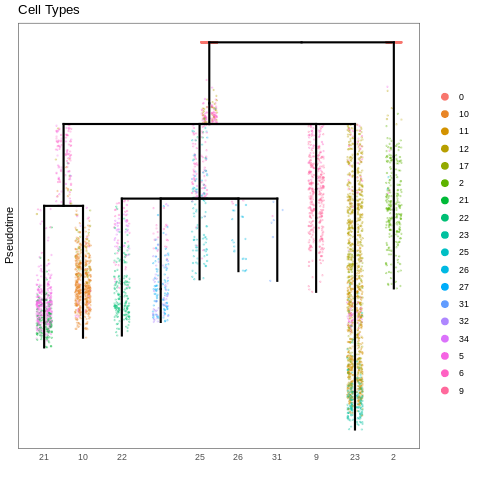

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","21","10", "2"), pseudotime 50
plotTree(lin.tree, "stage", title="Cell Types")

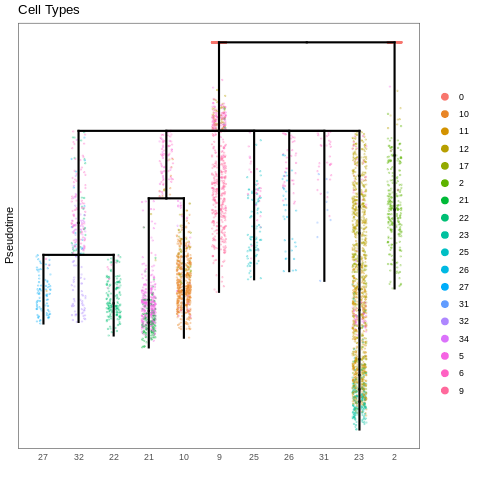

In [ ]:
%%R
#c("26","31","9","27","25","32","22", "23","21","10", "2"), pseudotime 30
plotTree(lin.tree, "stage", title="Cell Types")

#### **Regression Analysis for Pseudotime-related Genes**

In [51]:
#Make dataframe from pseudotime DE results from URD
deGenesSeg = pd.read_csv('deGenesSeg.csv')

deGenesSeg = annotateResDF(deGenesSeg)
deGenesSeg.head()

Genes  ...                                            goTerms
0  XLOC_002572  ...                                              [nan]
1  XLOC_043404  ...                                              [nan]
2  XLOC_013310  ...                                              [nan]
3  XLOC_036371  ...  [GO:0005737,GO:0044238,GO:0019538,GO:0009987,G...
4  XLOC_044566  ...                                              [nan]

[5 rows x 7 columns]

In [52]:
deGenesSeg.to_csv('deGenesSeg_Annos.csv')

View of AnnData object with n_obs × n_vars = 6115 × 4000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'log1p', 'hvg'
         Falling back to preprocessing with `sc.pp.pca` and default params.


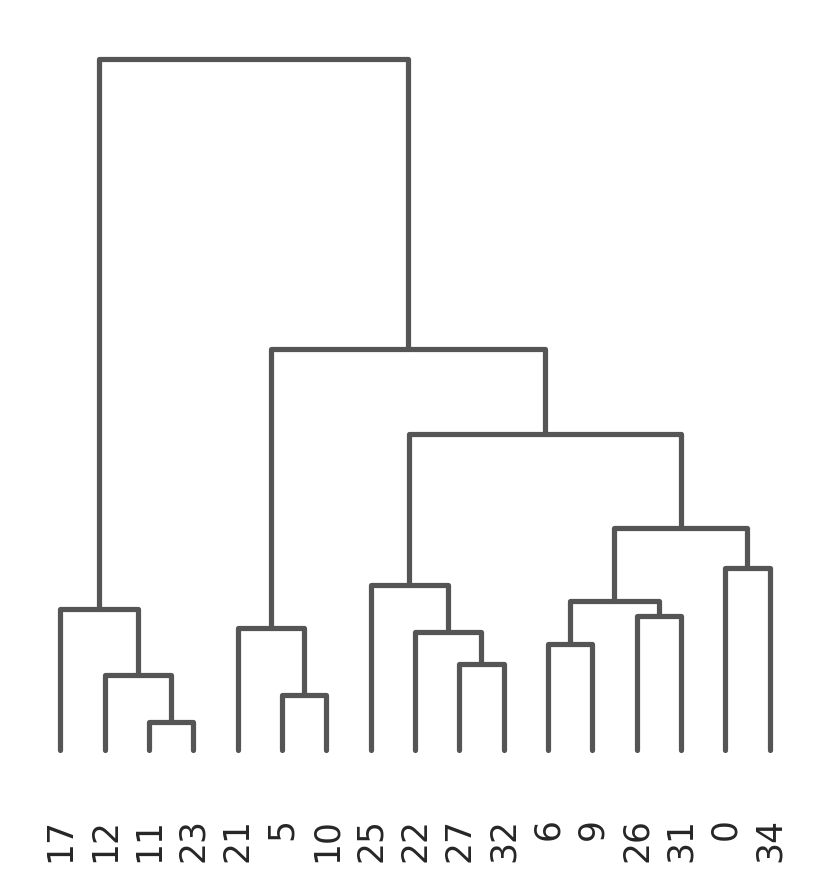

In [ ]:
#Check all cells + neurons (31,26,6,9)
neur_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,27,25,32,34,22,5,10,21,11,12,17,23])]
neur_lin

neur_lin_copy = neur_lin.copy()


#neur_lin_copy = neur_lin_copy[neur_lin_copy.obs['cellRanger_louvain'] != 17]

sc.pp.filter_cells(neur_lin_copy, min_counts=0)
sc.pp.filter_genes(neur_lin_copy, min_counts=1)
sc.pp.normalize_per_cell(neur_lin_copy, counts_per_cell_after=1e4)

sc.pp.log1p(neur_lin_copy)


sc.pp.highly_variable_genes(neur_lin_copy, n_top_genes=4000,n_bins=50)

neur_lin_copy = neur_lin_copy[:,neur_lin_copy.var['highly_variable']]

print(neur_lin_copy)

sc.tl.dendrogram(neur_lin_copy,'cellRanger_louvain',linkage_method='ward')
neur_lin_copy.uns['dendrogram_cellRanger_louvain'] = neur_lin_copy.uns["dendrogram_['cellRanger_louvain']"]
sc.pl.dendrogram(neur_lin_copy,'cellRanger_louvain')

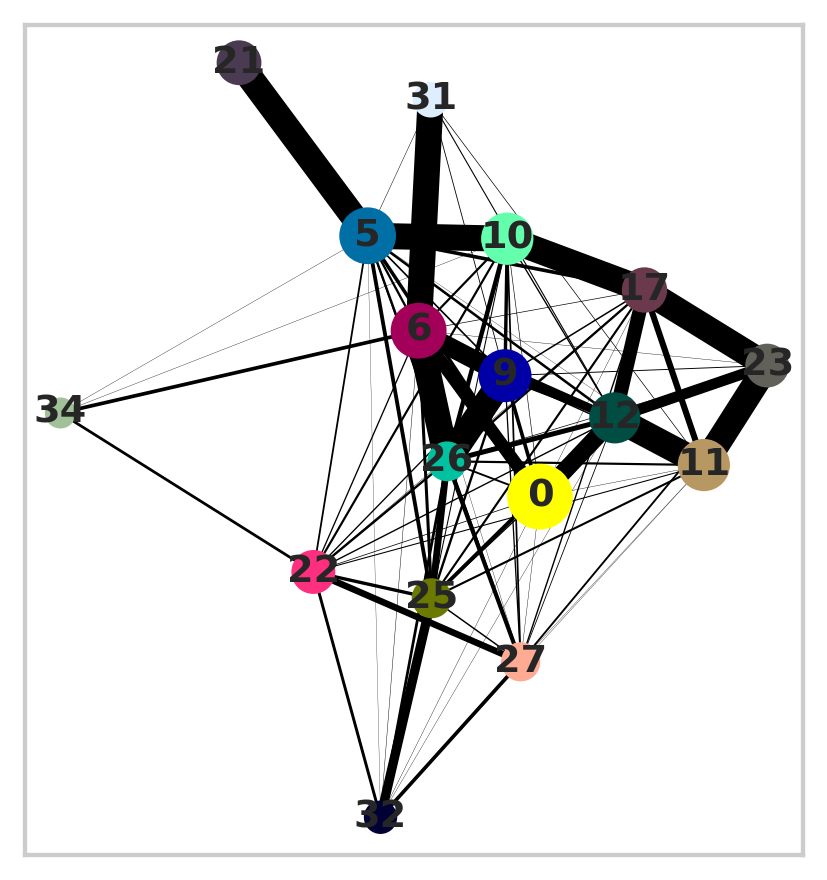

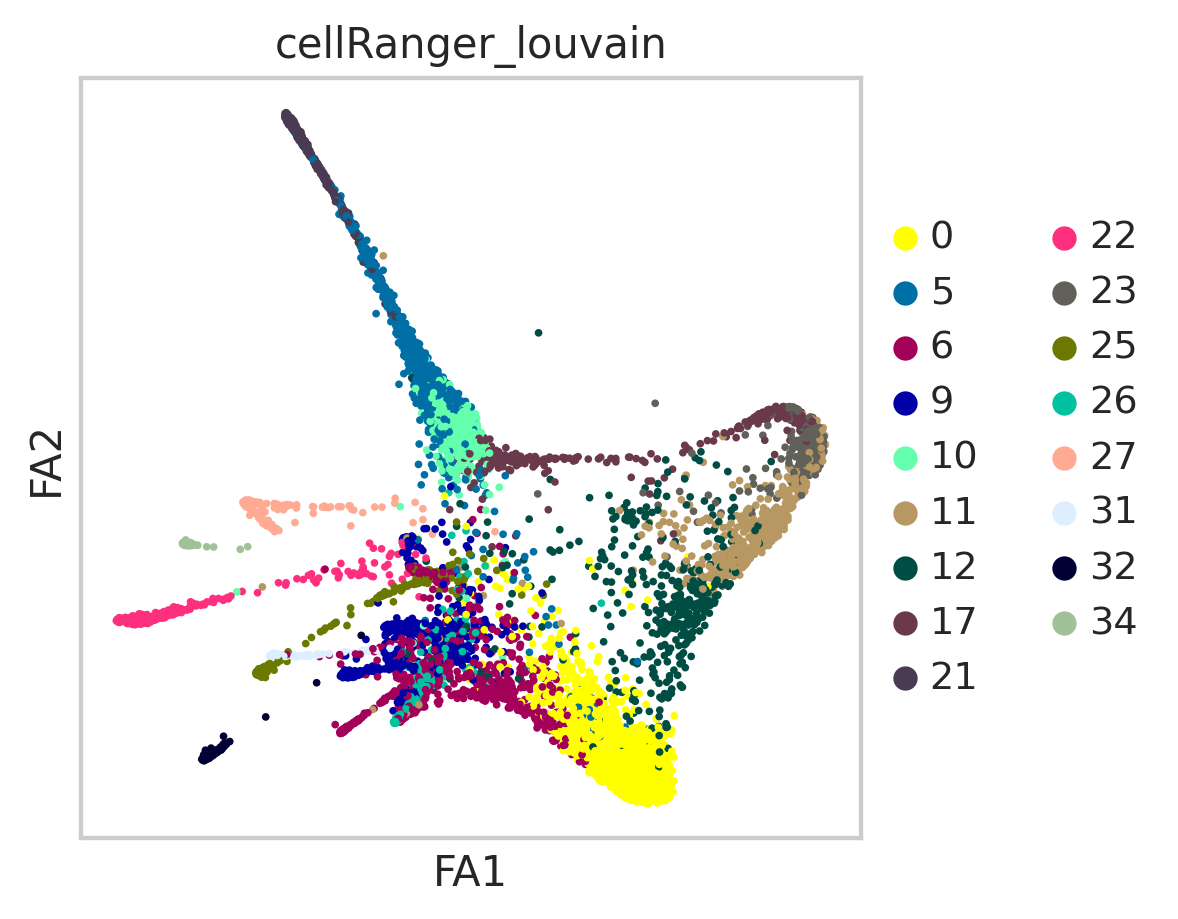

In [ ]:
sc.pp.scale(neur_lin_copy, max_value=10)
sc.tl.pca(neur_lin_copy, n_comps=60)
#sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
sc.pp.neighbors(neur_lin_copy,n_neighbors=50, n_pcs=15,method='gauss')

#sc.tl.louvain(big_lin_scaled,resolution=1,key_added='louvain_test')#Clustering algorithm,resolution=0.5


sc.tl.paga(neur_lin_copy, groups='cellRanger_louvain',)
sc.pl.paga(neur_lin_copy, color=['cellRanger_louvain'])

sc.tl.draw_graph(neur_lin_copy, init_pos='paga')

#Calculate pseudotime with diffusion components (dim reduction)

neur_lin_copy.uns['iroot'] = np.flatnonzero(neur_lin_copy.obs['cellRanger_louvain']  == 0)[0]
sc.tl.diffmap(neur_lin_copy,n_comps=10)
sc.tl.dpt(neur_lin_copy,n_dcs=10)

sc.pl.draw_graph(neur_lin_copy, color=['cellRanger_louvain'], color_map='viridis') #legend_loc='on data', 'dpt_pseudotime'

Run Regression for Hair Cells and i-cell + precursor populations

In [ ]:
def makeDPT(adata):
  lin_copy = adata.copy()

  sc.pp.scale(lin_copy, max_value=10)
  sc.tl.pca(lin_copy, n_comps=60)
  #sc.pl.pca_variance_ratio(neur_lin_scaled, log=True)
  sc.pp.neighbors(lin_copy,n_neighbors=50, n_pcs=15,method='gauss')

  sc.tl.paga(lin_copy, groups='cellRanger_louvain',)
  sc.pl.paga(lin_copy, color=['cellRanger_louvain'])

  sc.tl.draw_graph(lin_copy, init_pos='paga')

  #Calculate pseudotime with diffusion components (dim reduction)

  lin_copy.uns['iroot'] = np.flatnonzero(lin_copy.obs['cellRanger_louvain']  == 0)[0]
  sc.tl.diffmap(lin_copy,n_comps=10)
  sc.tl.dpt(lin_copy,n_dcs=10)

  #Convert pseudotime values to quantiles of pseudotime 
  adata.obs['dpt_pseudotime'] = lin_copy.obs['dpt_pseudotime']

  nbins = 20 #quantiles
  rangeList = range(0,nbins)
  strList = [str(i) for i in rangeList]

  adata.obs['quantTimeBlocks'] = pd.qcut(adata.obs['dpt_pseudotime'],q=nbins,labels=strList)

  adata.uns['paga'] = lin_copy.uns['paga'] 

  adata.uns['draw_graph'] = lin_copy.uns['draw_graph']

  adata.obsm['X_draw_graph_fa'] = lin_copy.obsm['X_draw_graph_fa']  

  return adata

In [ ]:
#Check all cells + neurons (31,26,6,9)
neur_lin = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([31,26,6,9,0,27,25,32,34,22,5,10,21,11,12,17,23])]
neur_lin

#io.mmwrite('neurLineage.mtx', neur_lin.X)

mechano_lin = neur_lin[neur_lin.obs['cellRanger_louvain'].isin([5,21,6,0])]
matureNem_lin = neur_lin[neur_lin.obs['cellRanger_louvain'].isin([0,5,17,10])] #Come back to this


Trying to set attribute `.obs` of view, copying.


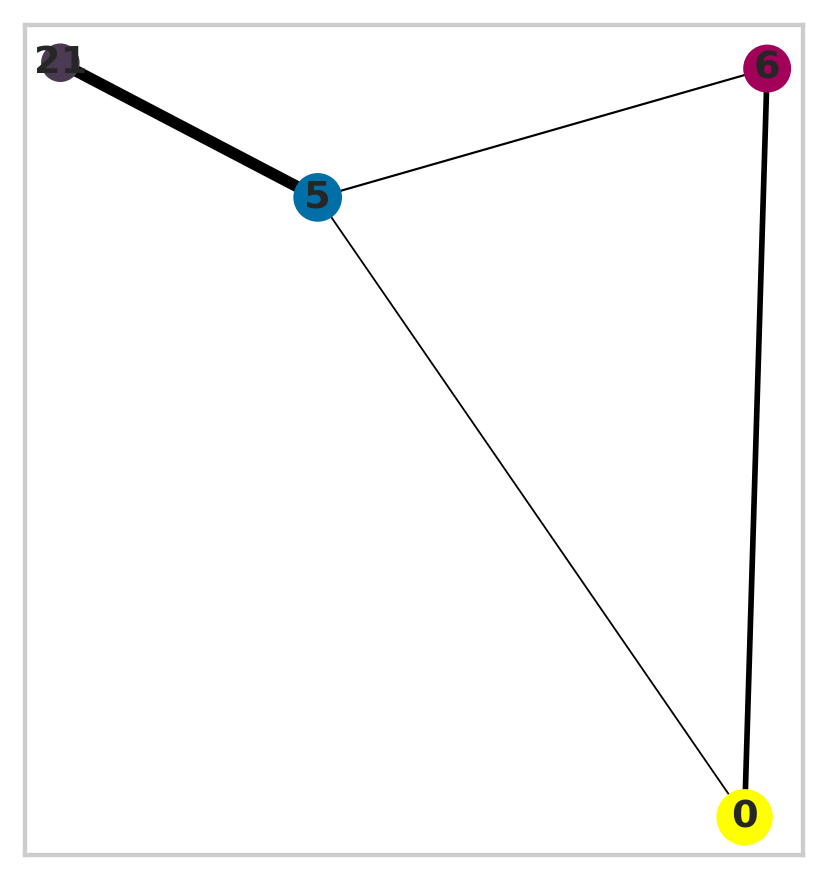

Trying to set attribute `.obs` of view, copying.


In [ ]:
#Normalize for pseudotime calculations
sc.pp.filter_cells(mechano_lin, min_counts=0)
sc.pp.filter_genes(mechano_lin, min_counts=1)
sc.pp.normalize_per_cell(mechano_lin, counts_per_cell_after=1e4)
sc.pp.log1p(mechano_lin)

sc.pp.highly_variable_genes(mechano_lin, n_top_genes=10000,n_bins=10) 

mechano_lin = mechano_lin[:,mechano_lin.var['highly_variable']]

mechano_lin = makeDPT(mechano_lin)

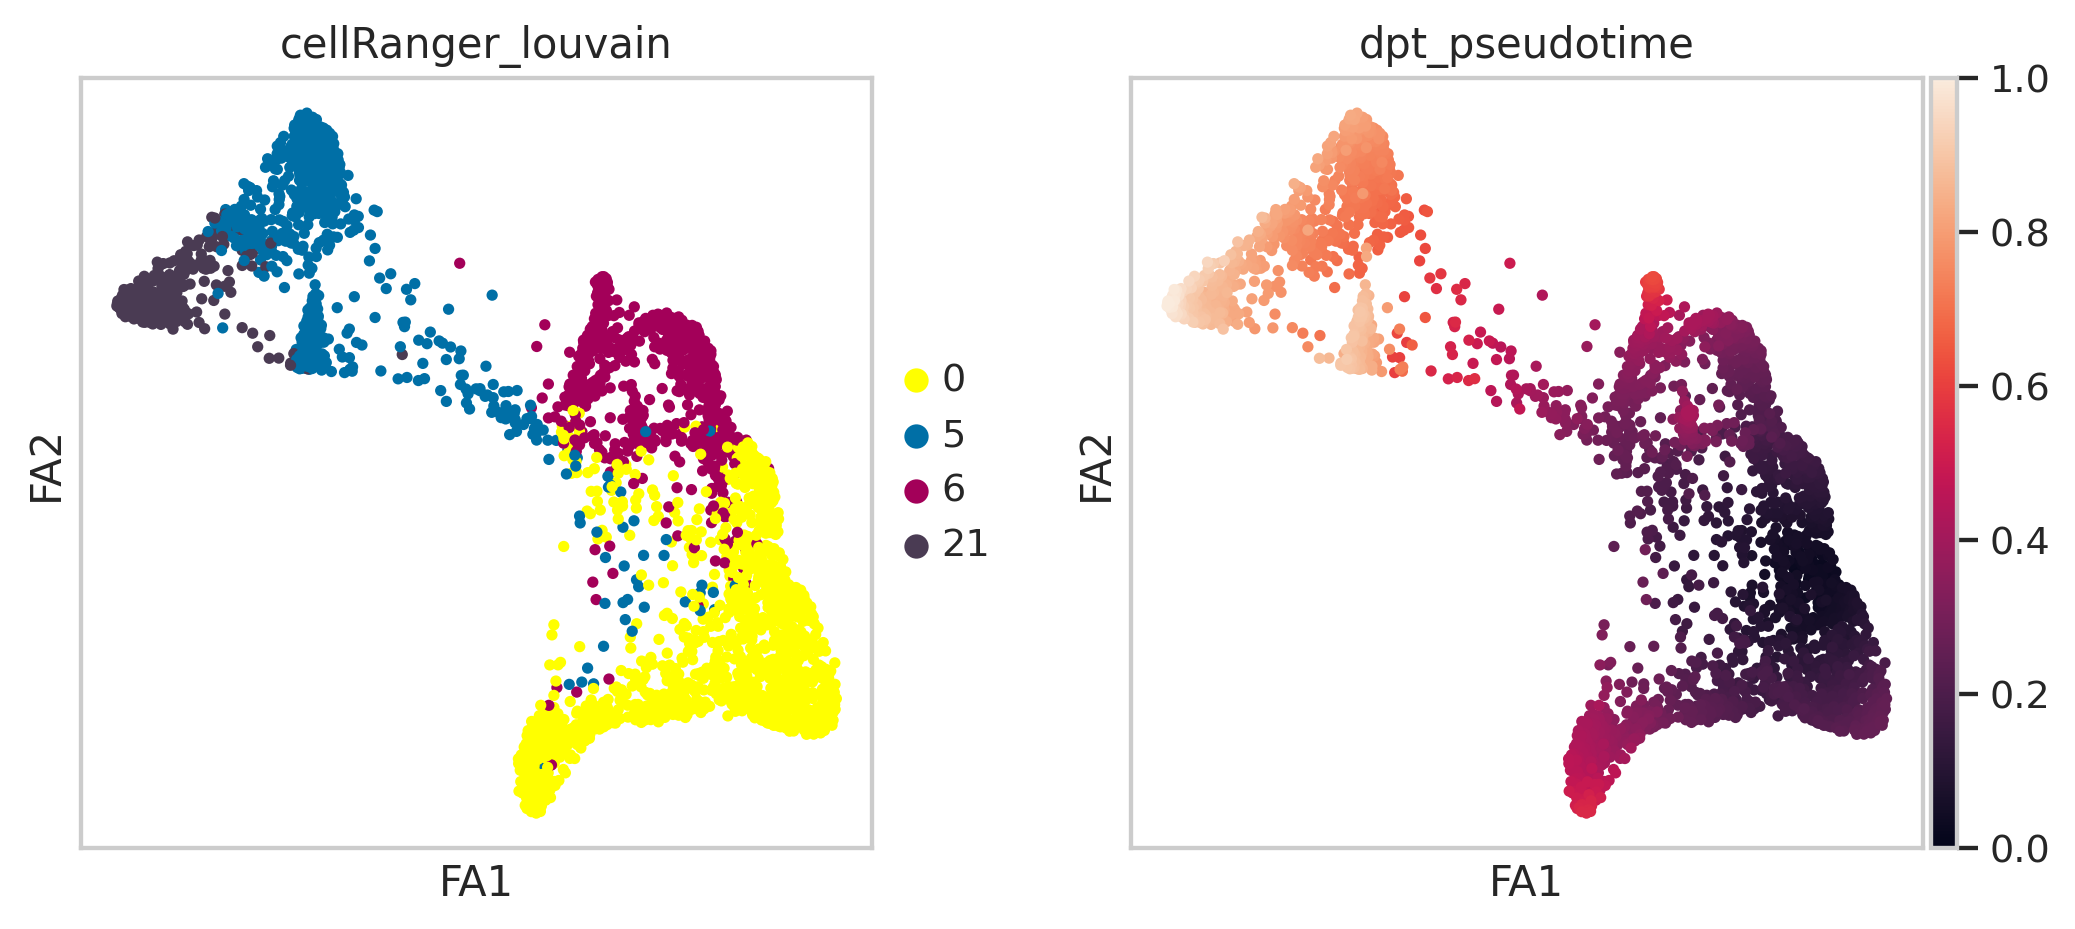

In [ ]:
sc.pl.draw_graph(mechano_lin, color=['cellRanger_louvain','dpt_pseudotime'])

In [ ]:
#Run regression

result_mechano = runRegr_dptPseudotime(mechano_lin,mechano_lin,'quantTimeBlocks')

0.9332755750155095


In [ ]:
#Make dataframe from regression results
mechano_gene_res = resToDF(result_mechano,mechano_lin)

1698


In [ ]:
mechano_gene_res = annotateResDF(mechano_gene_res)
mechano_gene_res.head()

Genes  ...                                            goTerms
1544  XLOC_005491  ...  [GO:0045298,GO:0005856,GO:0005200,GO:0005622,G...
813   XLOC_002790  ...  [GO:0005737,GO:0005622,GO:0032991,GO:0005840,G...
332   XLOC_001126  ...                                                 NA
1408  XLOC_004980  ...                                              [nan]
5946  XLOC_028709  ...                                              [nan]

[5 rows x 8 columns]

In [ ]:
mechano_gene_res.to_csv('mechano_stem_lineage_pseudotime_genes.csv',index=None)

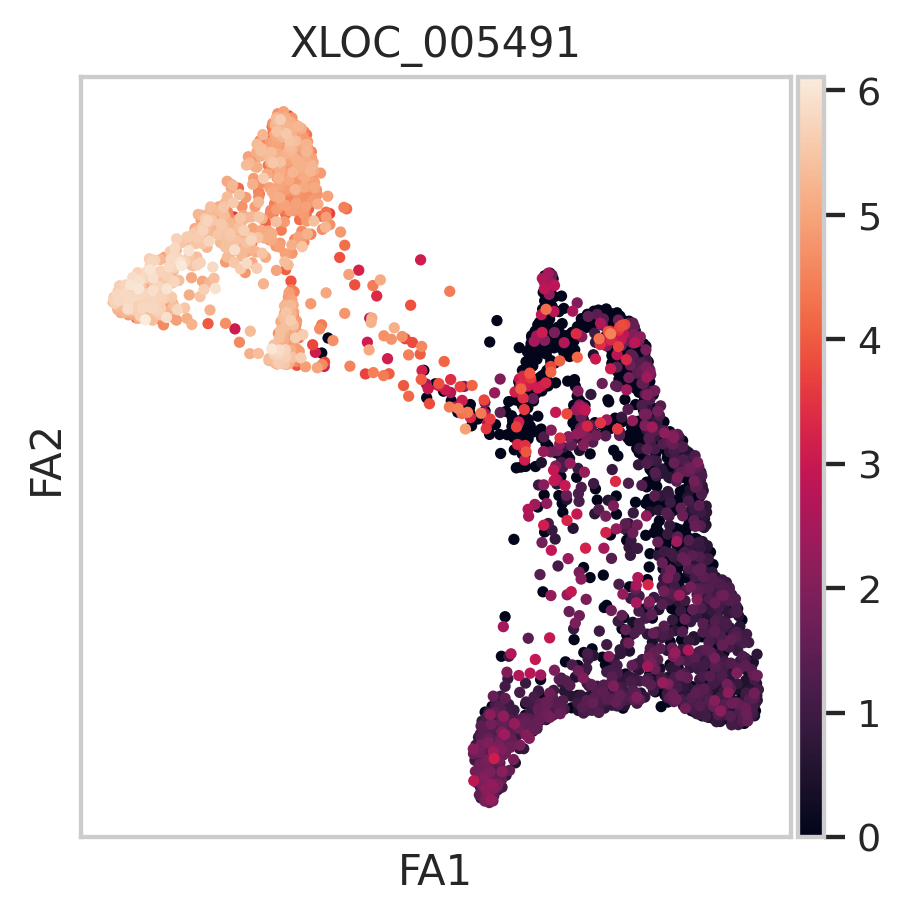

In [ ]:
sc.pl.draw_graph(mechano_lin, color=['XLOC_005491'])